In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.graphics.gofplots import qqplot
import numpy as np
from math import isnan
from itertools import chain
plt.style.use('seaborn')
import seaborn as sns

# Demographics

In [2]:
data = pd.read_csv("pilot3/data.csv")
# Making sure the condition and responses are the same
data.condition = data.condition.apply(lambda x: x.lower())

In [4]:
def remove_participants(df):
    '''
    Remove participants that do not pass comprehension check
    in at most 3 tries
    '''
    limit = 3
    num_asks = 3
    threshold = limit*num_asks
    group = df.groupby(["subject_id"])
    subjs = list(group.attempts.count()[group.attempts.count() > threshold].index)
    return df[~df["subject_id"].isin(subjs)]

def drop_columns(df):
    '''
    Drop unused columns
    '''
    return df.drop(columns=["failed_video","failed_audio","failed_images",
                           "internal_node_id","timeout", "stimulus",
                            "study_id","session_id","success","attempts",
                           "trial_type","time_elapsed", "value"])

def adjust_trial_index(df):
    '''
    Reindex the 48 trial indices from [21-N] to [0-N]
    '''
    indices = list(range(48))
    df['trial_index'] = indices
    return df

In [5]:
# Dataframe containing only the trial responses
responses = data[data.task == 'response']
# Dropping columns
responses = drop_columns(responses)
# Reset index
responses = responses.reset_index(drop=True)
# Rename columns
responses = responses.rename(columns={'condition':'exp_condition',
                                     'response': 'response_'})
# Reindexing the trial indices from [21-N] to [0-N]
responses = responses.groupby('subject_id').apply(adjust_trial_index)
# Limiting response times to the timout max
responses.rt = responses.rt.apply(lambda x: 5000 if pd.isna(x) else x)
responses.rt = responses.rt.apply(lambda x: 5000 if x > 5000 else x)
# Z-Score RT
responses['zrt'] = (responses['rt'] - responses['rt'].mean())/responses['rt'].std(ddof=0)
# Taking the log(RT) and adding to dataframe
responses["log_rt"] = responses.rt.apply(lambda x: np.log(x))
# Z-score log RT
responses['zlogrt'] = (responses['log_rt'] - responses['log_rt'].mean())/responses['log_rt'].std(ddof=0)
# Adding per-trial condition (i.e. was the correct answer yes or no)
responses['trial_condition'] = responses.correct_response == responses.exp_condition
responses['trial_condition'] = responses.trial_condition.apply(lambda x: "Yes" if x else "No")
# Recoding the responses as "yes" or "no" instead of condition-dependent key
responses['response'] = responses.exp_condition == responses.response_
responses['response'] = responses.response.apply(lambda x: "Yes" if x else "No")
# Adding per-participant accuracy to the dataframe
responses['participant_accuracy'] = responses.groupby('subject_id')['correct'].transform('sum')/len(responses.groupby('trial_index'))
responses['trial_accuracy'] = responses.groupby('trial_index')['correct'].transform('sum')/len(responses.groupby('subject_id'))
responses['scene_accuracy'] = responses.groupby('scene')['correct'].transform('sum')/len(responses.groupby('subject_id'))
# Split scene conditions into simulation time and collision-no-collision
responses = pd.concat([responses, responses.scene.str.split("_", expand=True)],axis=1)
responses = responses.rename(columns={0:'sim_time',
                             1: 'collision'})
responses['collision'] = responses['collision'].str.replace('\d+', '')

<ipython-input-5-cb815ce98a68>:35: FutureWarning: The default value of regex will change from True to False in a future version.
  responses['collision'] = responses['collision'].str.replace('\d+', '')


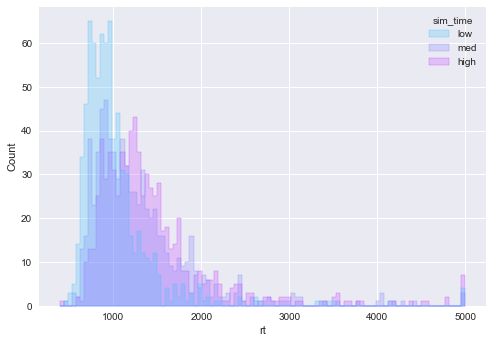

In [6]:
sns.histplot(x="rt", data=responses, bins=100,hue="sim_time",element="step",palette="cool");

In [7]:
def compare(item1):
    '''
    Comparator for sorting scenes
    '''
    if item1[0] == 'l':
        return -1
    elif item1[0] == 'm':
        return 0
    else:
        return 1

# Gather scenes
scenes = list(responses.scene.unique())
# Sort them according to our comparison function
scenes.sort(reverse=False,key=compare)
# Create new index
index = list(range(len(scenes)))
# Create mapping from scenes to index
scene_index_map = {s:i for s,i in zip(scenes,index)}
# Create index in response dataframe
responses.scene_index = responses.scene.apply(lambda x: scene_index_map[x])

In [8]:
# Remove outliers
clean_responses = responses[abs(responses.zrt) <= 2]
clean_responses

,trial_index,subject_id,exp_condition,rt,response_,task,correct_response,correct,task_condition,scene,...,zlogrt,trial_condition,response,participant_accuracy,trial_accuracy,scene_accuracy,sim_time,collision,2,3
0,0,61716480d6da1714ff60ed0d,j,884.0,f,response,f,True,No,low_nocol_yessp_1.mp4,...,-0.689882,No,No,0.895833,0.765957,0.936170,low,nocol,yessp,1.mp4
1,1,61716480d6da1714ff60ed0d,j,726.0,f,response,j,False,Yes,low_yescol_yessp_2.mp4,...,-1.200066,Yes,No,0.895833,0.702128,0.872340,low,yescol,yessp,2.mp4
2,2,61716480d6da1714ff60ed0d,j,885.0,f,response,f,True,No,low_nocol_nosp_2.mp4,...,-0.686952,No,No,0.895833,0.914894,0.893617,low,nocol,nosp,2.mp4
3,3,61716480d6da1714ff60ed0d,j,981.0,f,response,f,True,No,med_nocol_nosp_3.mp4,...,-0.420120,No,No,0.895833,0.787234,0.914894,med,nocol,nosp,3.mp4
4,4,61716480d6da1714ff60ed0d,j,1189.0,j,response,j,True,Yes,high_yescol_yessp_2.mp4,...,0.078116,Yes,Yes,0.895833,0.893617,1.000000,high,yescol,yessp,2.mp4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,43,5f145461435271023220d6ac,j,1551.0,f,response,f,True,No,med_nocol_nosp_1.mp4,...,0.766768,No,No,0.916667,0.872340,0.936170,med,nocol,nosp,1.mp4
2252,44,5f145461435271023220d6ac,j,1231.0,f,response,f,True,No,high_nocol_nosp_1.mp4,...,0.168060,No,No,0.916667,0.914894,0.936170,high,nocol,nosp,1.mp4
2253,45,5f145461435271023220d6ac,j,791.0,f,response,f,True,No,med_nocol_nosp_2.mp4,...,-0.977894,No,No,0.916667,0.893617,0.957447,med,nocol,nosp,2.mp4
2254,46,5f145461435271023220d6ac,j,804.0,f,response,f,True,No,low_nocol_nosp_4.mp4,...,-0.935657,No,No,0.916667,0.829787,0.829787,low,nocol,nosp,4.mp4


# Plots

In [9]:
sns.set_style("whitegrid")
sns.set_palette("bone_r")

## Accuracy Per Collision Condition
Did accuracy change according to whether the ball was going to collide with the goal or not?

#### Conclusions
1. Accuracy is not normally-distributed for either collision condition (Shapiro, p < 8e-43)
2. Accuracy for No-Collision condition is significantly higher than for Yes-Collision condition (MWU, p = 0.009)

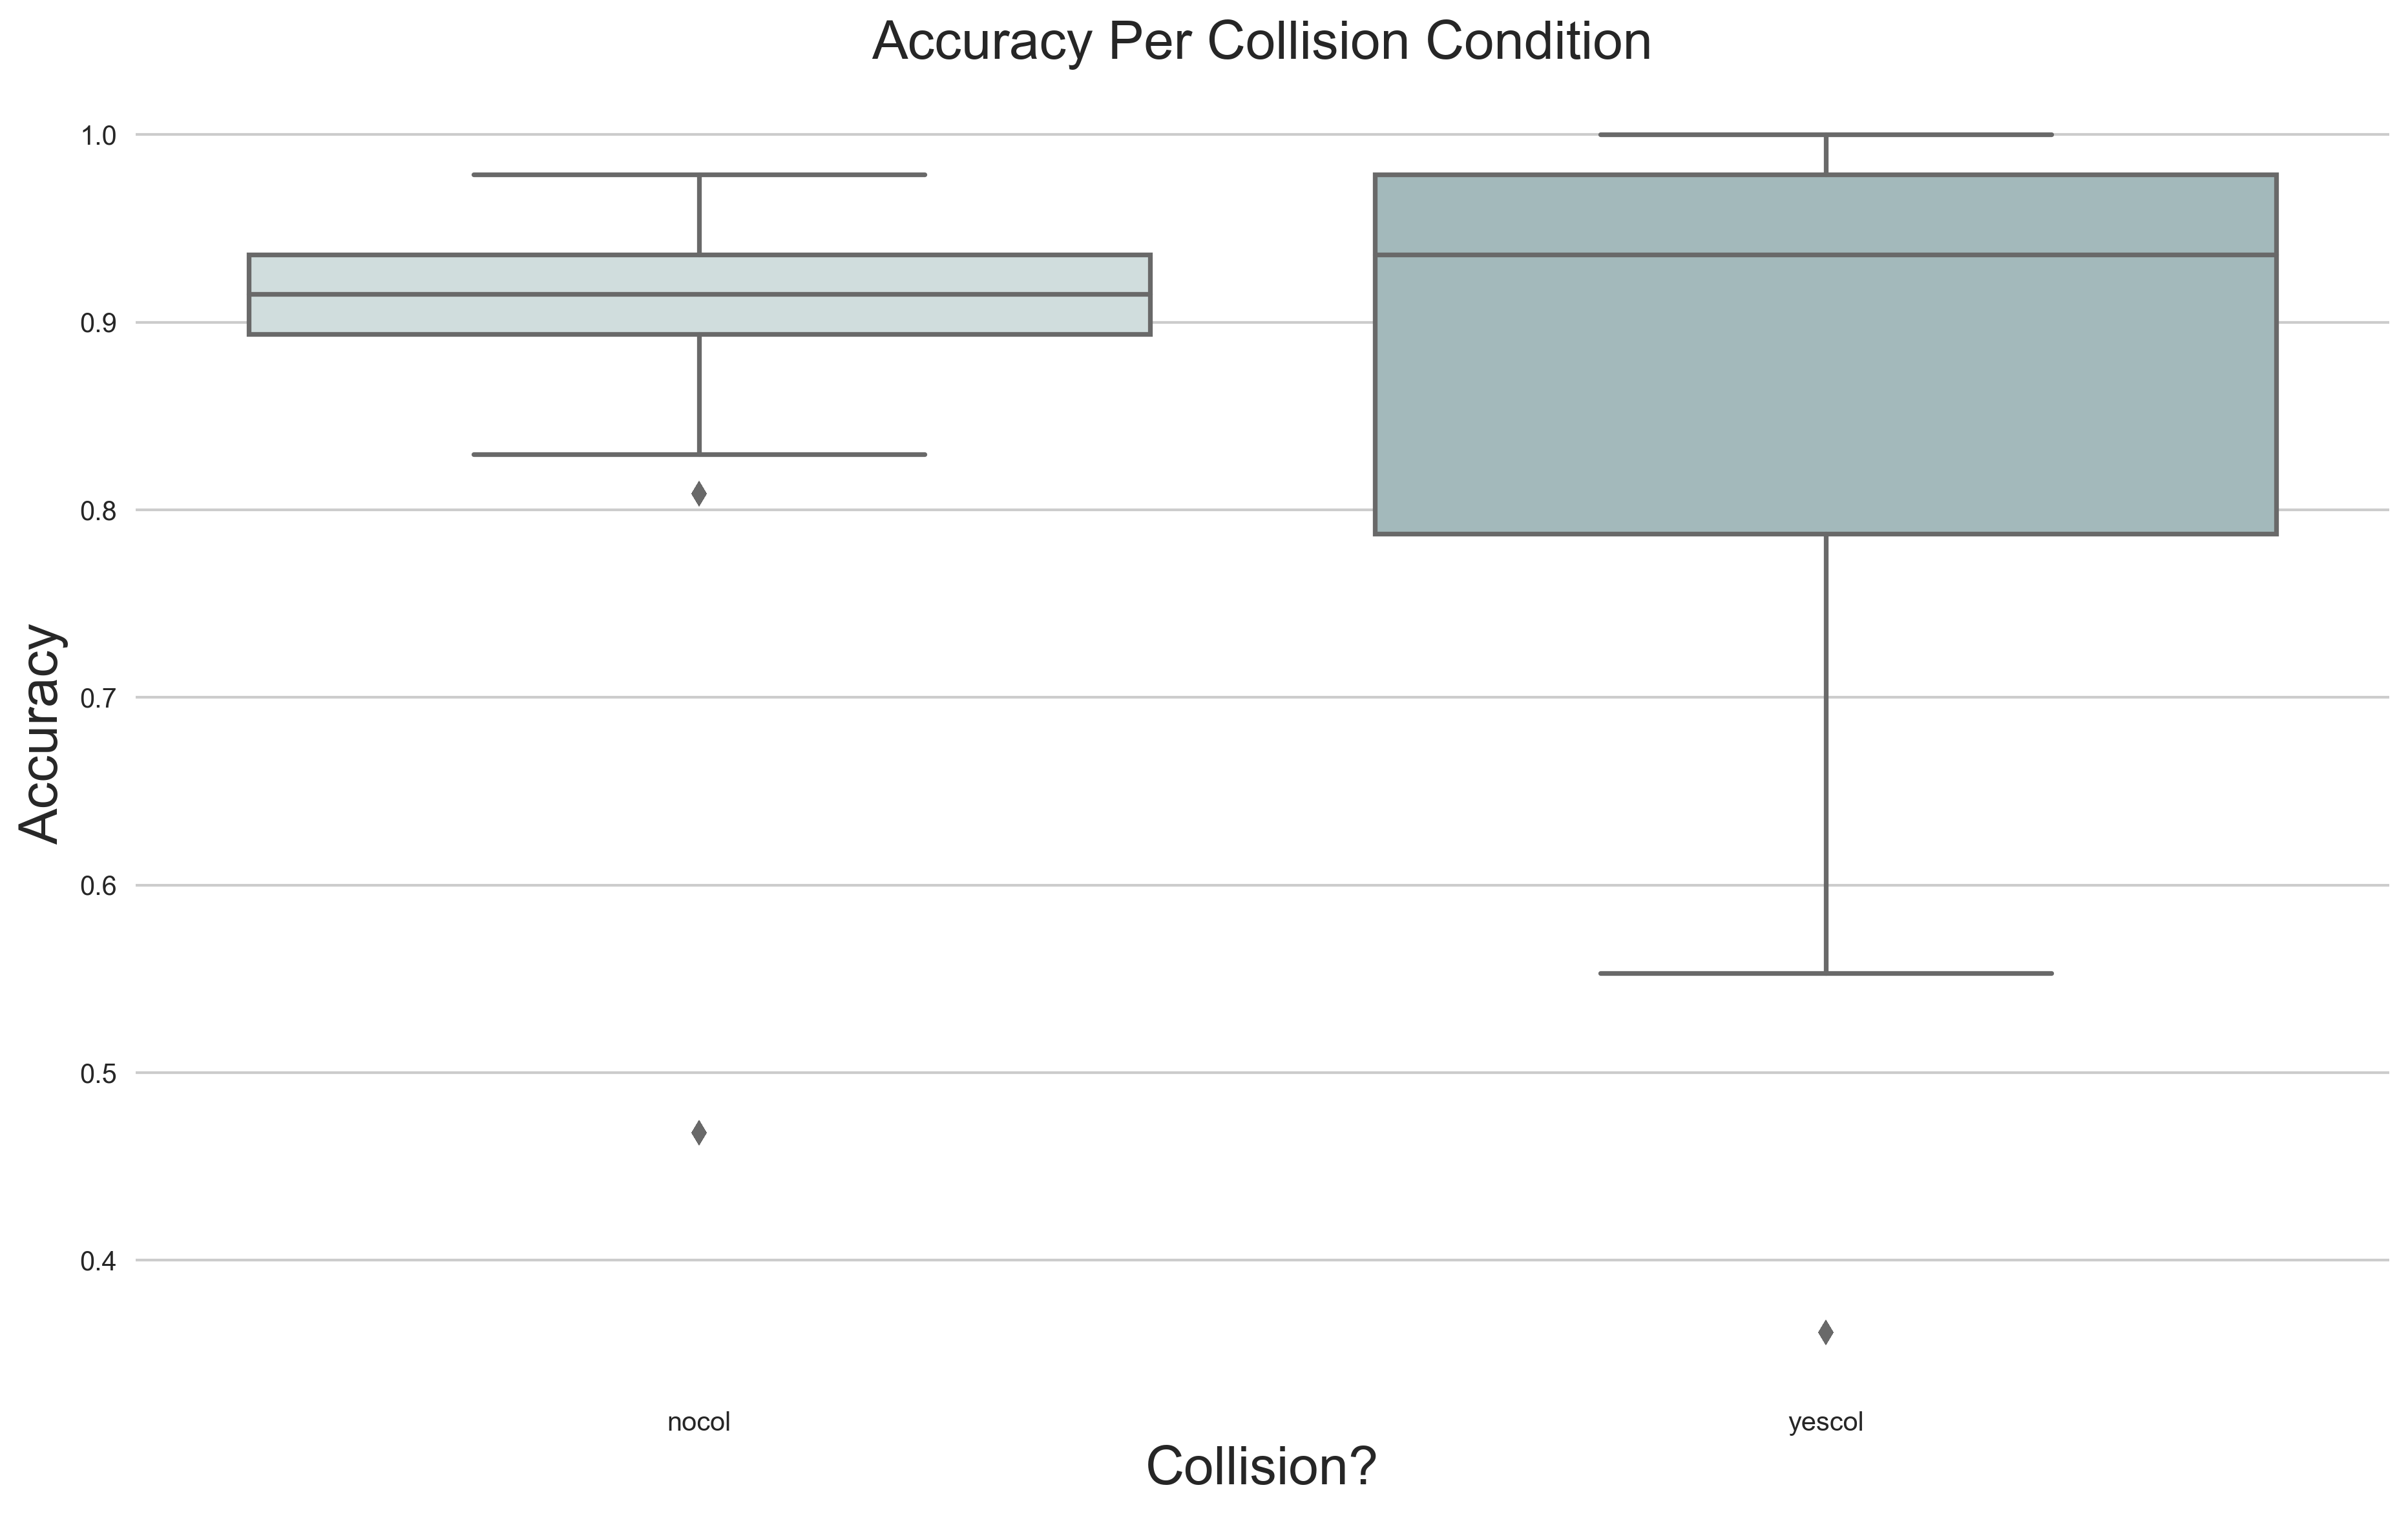

In [10]:
trial=clean_responses.groupby("trial_condition").scene_accuracy.apply(list)
figure(figsize=(15, 9), dpi=300)

sns.boxplot(y="scene_accuracy",x="collision",data=clean_responses)
# plt.xticks(rotation = 90)
plt.title("Accuracy Per Collision Condition",fontsize=20)
# plt.ylim(0,1)
# plt.xticks([1,2],[trial.index[0],trial.index[1]])
plt.xlabel("Collision?",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
# plt.tight_layout()
plt.show()

In [11]:
from scipy.stats import ttest_ind,mannwhitneyu,shapiro

no = list(clean_responses[(clean_responses["collision"]=="nocol")].scene_accuracy)
yes = list(clean_responses[(clean_responses["collision"]=="yescol")].scene_accuracy)

shap_yes = shapiro(yes)
shap_no = shapiro(no)

print(f"Yes Shapiro: {shap_yes}. Data is {'not' if shap_yes.pvalue < 0.05 else ''} normal.")
print(f"No Shapiro: {shap_no}. Data is {'not' if shap_no.pvalue < 0.05 else ''} normal.")
print("")

u_res = mannwhitneyu(no, yes, alternative="greater")


print(f"No-Yes U test statistic: {u_res}")

Yes Shapiro: ShapiroResult(statistic=0.8057644367218018, pvalue=4.09242297096033e-34). Data is not normal.
No Shapiro: ShapiroResult(statistic=0.5741549730300903, pvalue=2.802596928649634e-45). Data is not normal.

No-Yes U test statistic: MannwhitneyuResult(statistic=548646.5, pvalue=0.9963917287146093)


## Accuracy Per Simulation Condition
Did accuracy change according to simulation time?

#### Conclusions
1. Accuracy is not normally distributed across simulation-time conditions (Shapiro, p < 2e-28)
2. Accuracy is significantly higher in Low condition than Med condition (MWU, p=7e-11)
3. Accuracy is significantly higher in Med condition than High condition (MWU, p=2e-96)
4. Accuracy is significantly higher in Low condition than High condition (MWU, p=2e-132)

Text(0, 0.5, 'Accuracy')

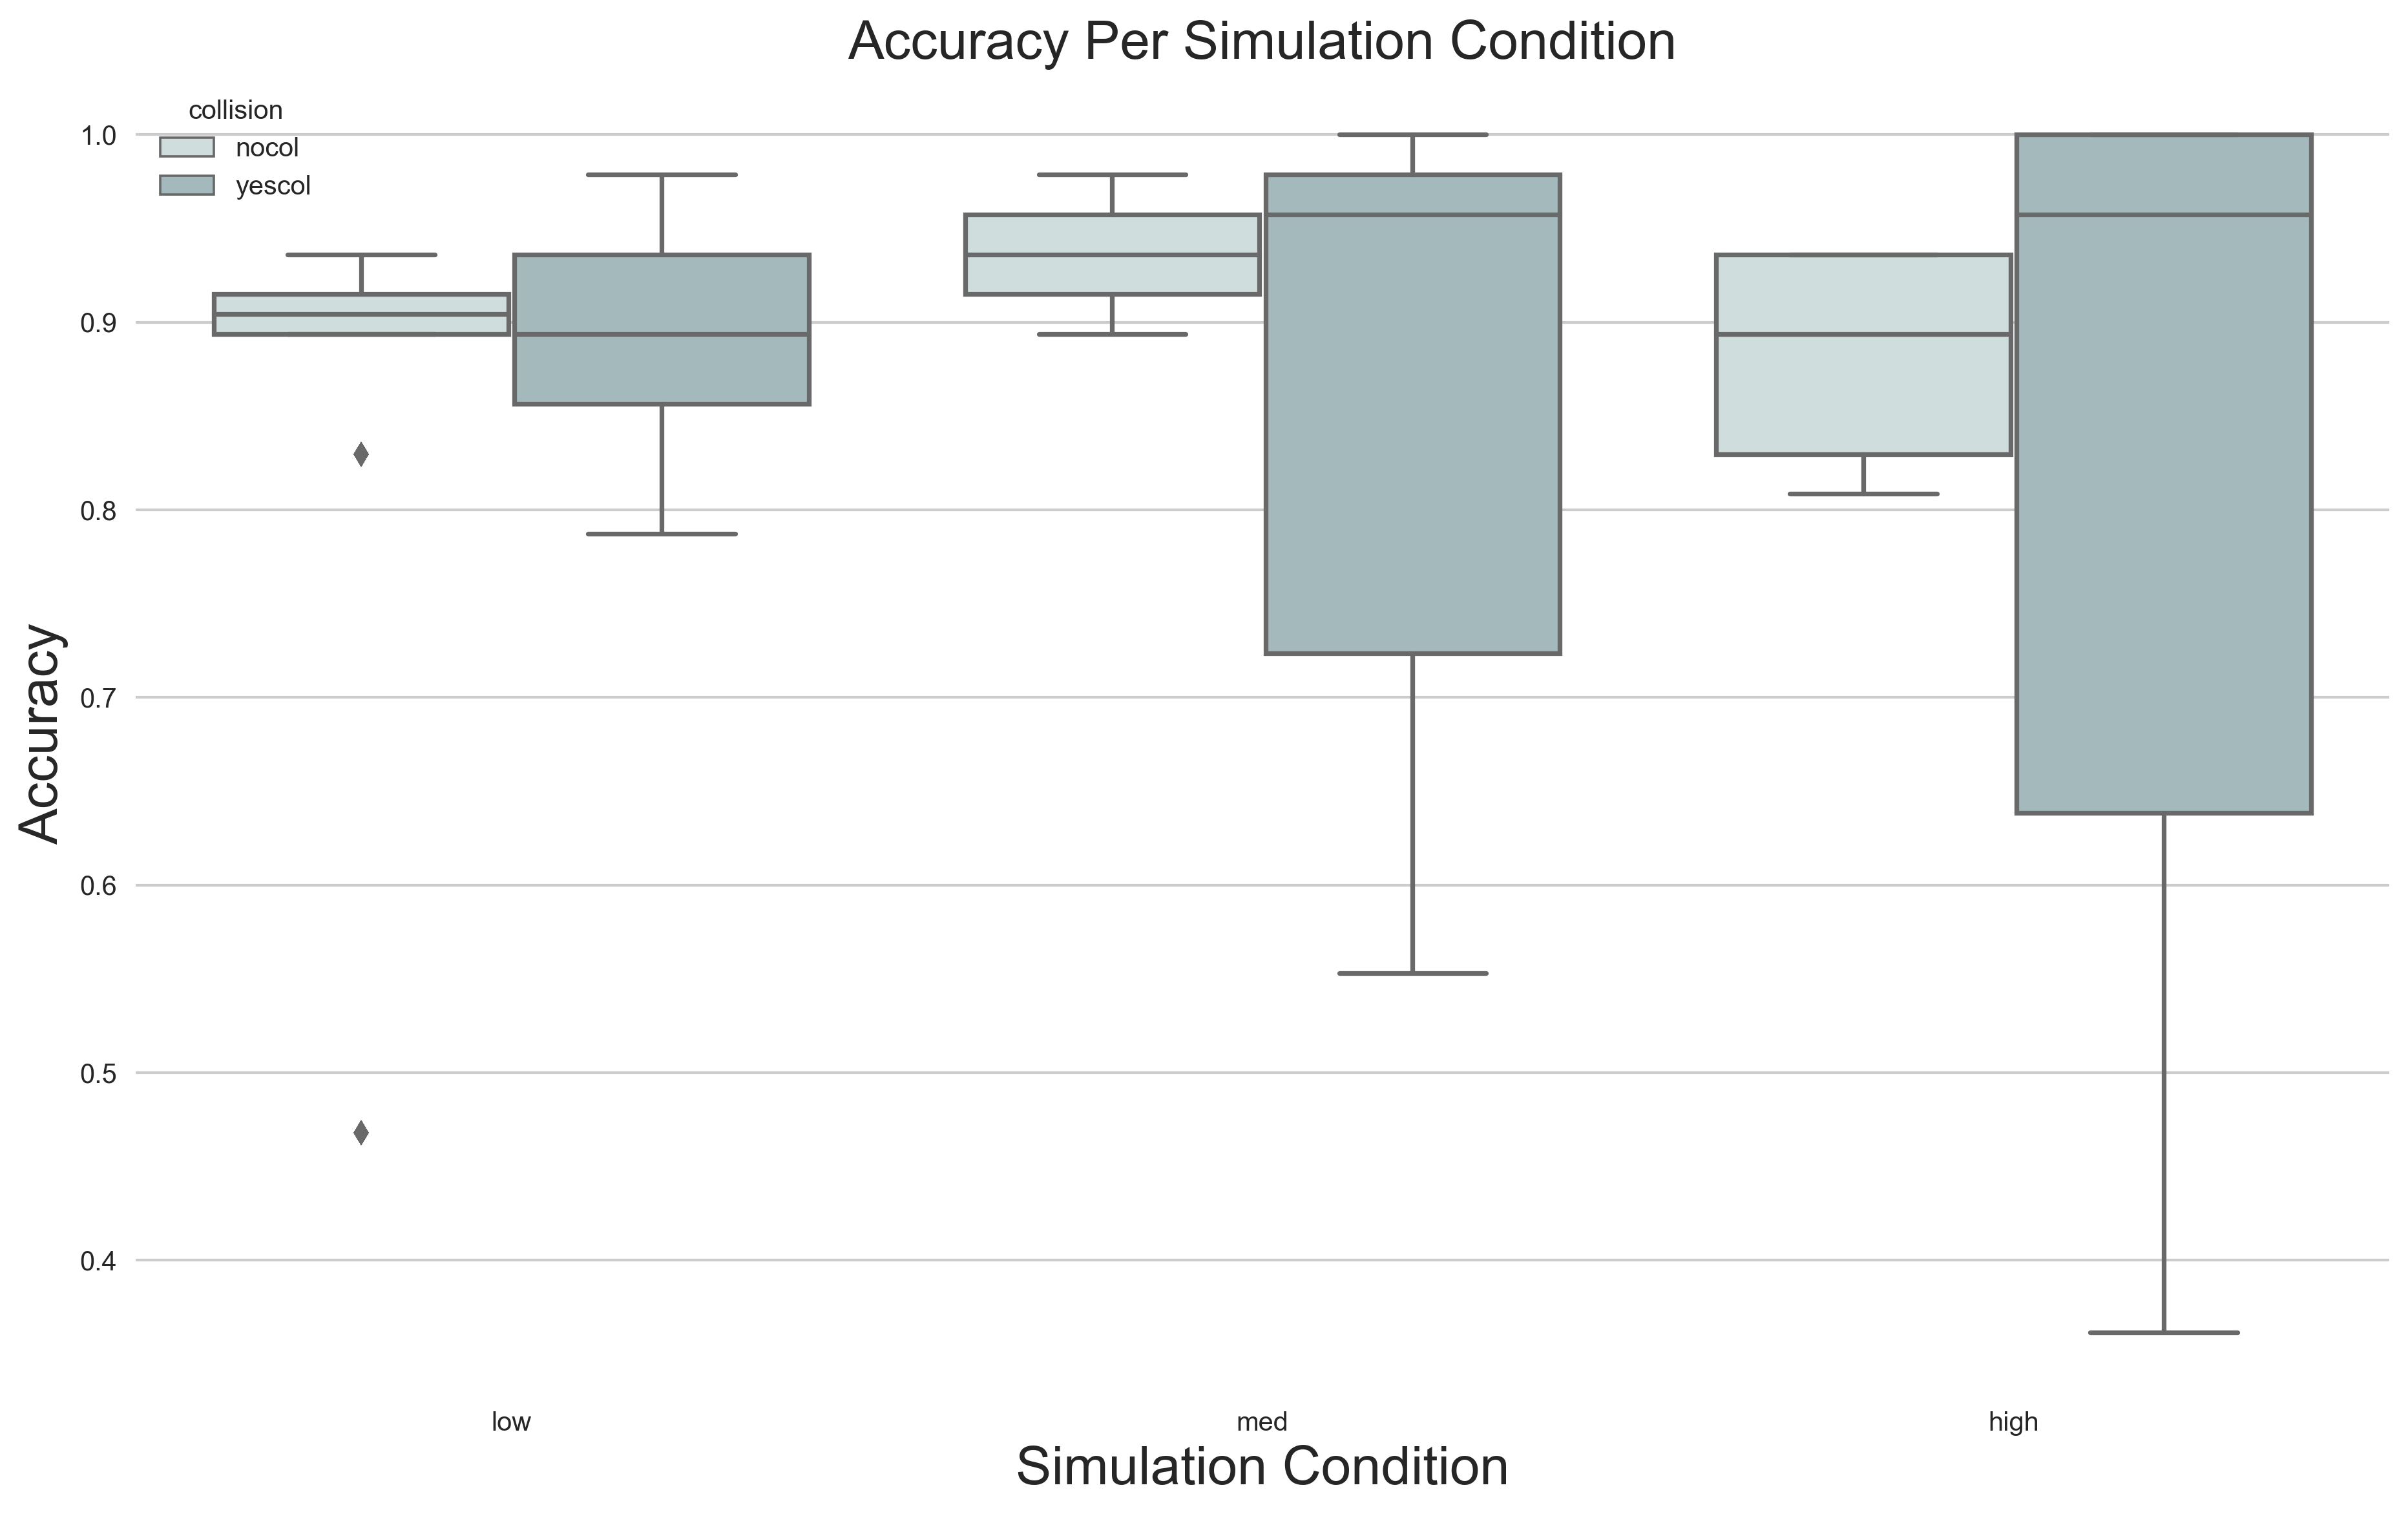

In [12]:
import seaborn as sns
custom_dict = {'low':0, 'med':1,'high':2}
trial=pd.DataFrame(clean_responses.groupby("sim_time").scene_accuracy.apply(list))
trial = trial.sort_values(by=['sim_time'],key=lambda x: x.map(custom_dict))

figure(figsize=(15, 9), dpi=300)

sns.boxplot(x="sim_time", y="scene_accuracy",data=clean_responses,order=['low','med','high'],hue="collision")
plt.title("Accuracy Per Simulation Condition",fontsize=20)
plt.xlabel("Simulation Condition",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)

In [13]:
from scipy.stats import ttest_ind,mannwhitneyu,shapiro

low = list(clean_responses[(clean_responses["sim_time"]=="low")].scene_accuracy)
med = list(clean_responses[(clean_responses["sim_time"]=="med")].scene_accuracy)
high = list(clean_responses[(clean_responses["sim_time"]=="high")].scene_accuracy)

shap_low = shapiro(low)
shap_med = shapiro(med)
shap_high = shapiro(high)

print(f"Low Shapiro: {shap_low}. Data is {'not' if shap_low.pvalue < 0.05 else ''} normal.")
print(f"Med Shapiro: {shap_med}. Data is {'not' if shap_med.pvalue < 0.05 else ''} normal.")
print(f"High Shapiro: {shap_high}. Data is {'not' if shap_high.pvalue < 0.05 else ''} normal.")
print("")

u_res = mannwhitneyu(low, med, alternative="greater")
u_res_mh = mannwhitneyu(med, high, alternative="greater")
u_res_lh = mannwhitneyu(low, high, alternative="greater")

print(f"Low-Med T test statistic: {u_res}")
print(f"Med-High U test statistic: {u_res_mh}")
print(f"Low-High U test statistic: {u_res_lh}")

Low Shapiro: ShapiroResult(statistic=0.6152485609054565, pvalue=1.3688881124031412e-37). Data is not normal.
Med Shapiro: ShapiroResult(statistic=0.703040361404419, pvalue=8.654191448845228e-34). Data is not normal.
High Shapiro: ShapiroResult(statistic=0.7911956906318665, pvalue=4.069287147992961e-29). Data is not normal.

Low-Med T test statistic: MannwhitneyuResult(statistic=178372.0, pvalue=1.0)
Med-High U test statistic: MannwhitneyuResult(statistic=315122.5, pvalue=3.570668863888498e-15)
Low-High U test statistic: MannwhitneyuResult(statistic=267189.0, pvalue=0.22436676615651402)


In [15]:
high_no = list(clean_responses[(clean_responses["sim_time"]=="high") & (clean_responses["collision"] == "nocol")].scene_accuracy)
high_yes = list(clean_responses[(clean_responses["sim_time"]=="high") & (clean_responses["collision"] == "yescol")].scene_accuracy)

u_res = mannwhitneyu(high_yes, high_no, alternative="less")

print(f"High-Yes High-No U test statistic: {u_res}")

High-Yes High-No U test statistic: MannwhitneyuResult(statistic=66780.0, pvalue=0.9521222142987803)


## RT Per Simulation Condition
Did RT change according to simulation time?

### Boxplot

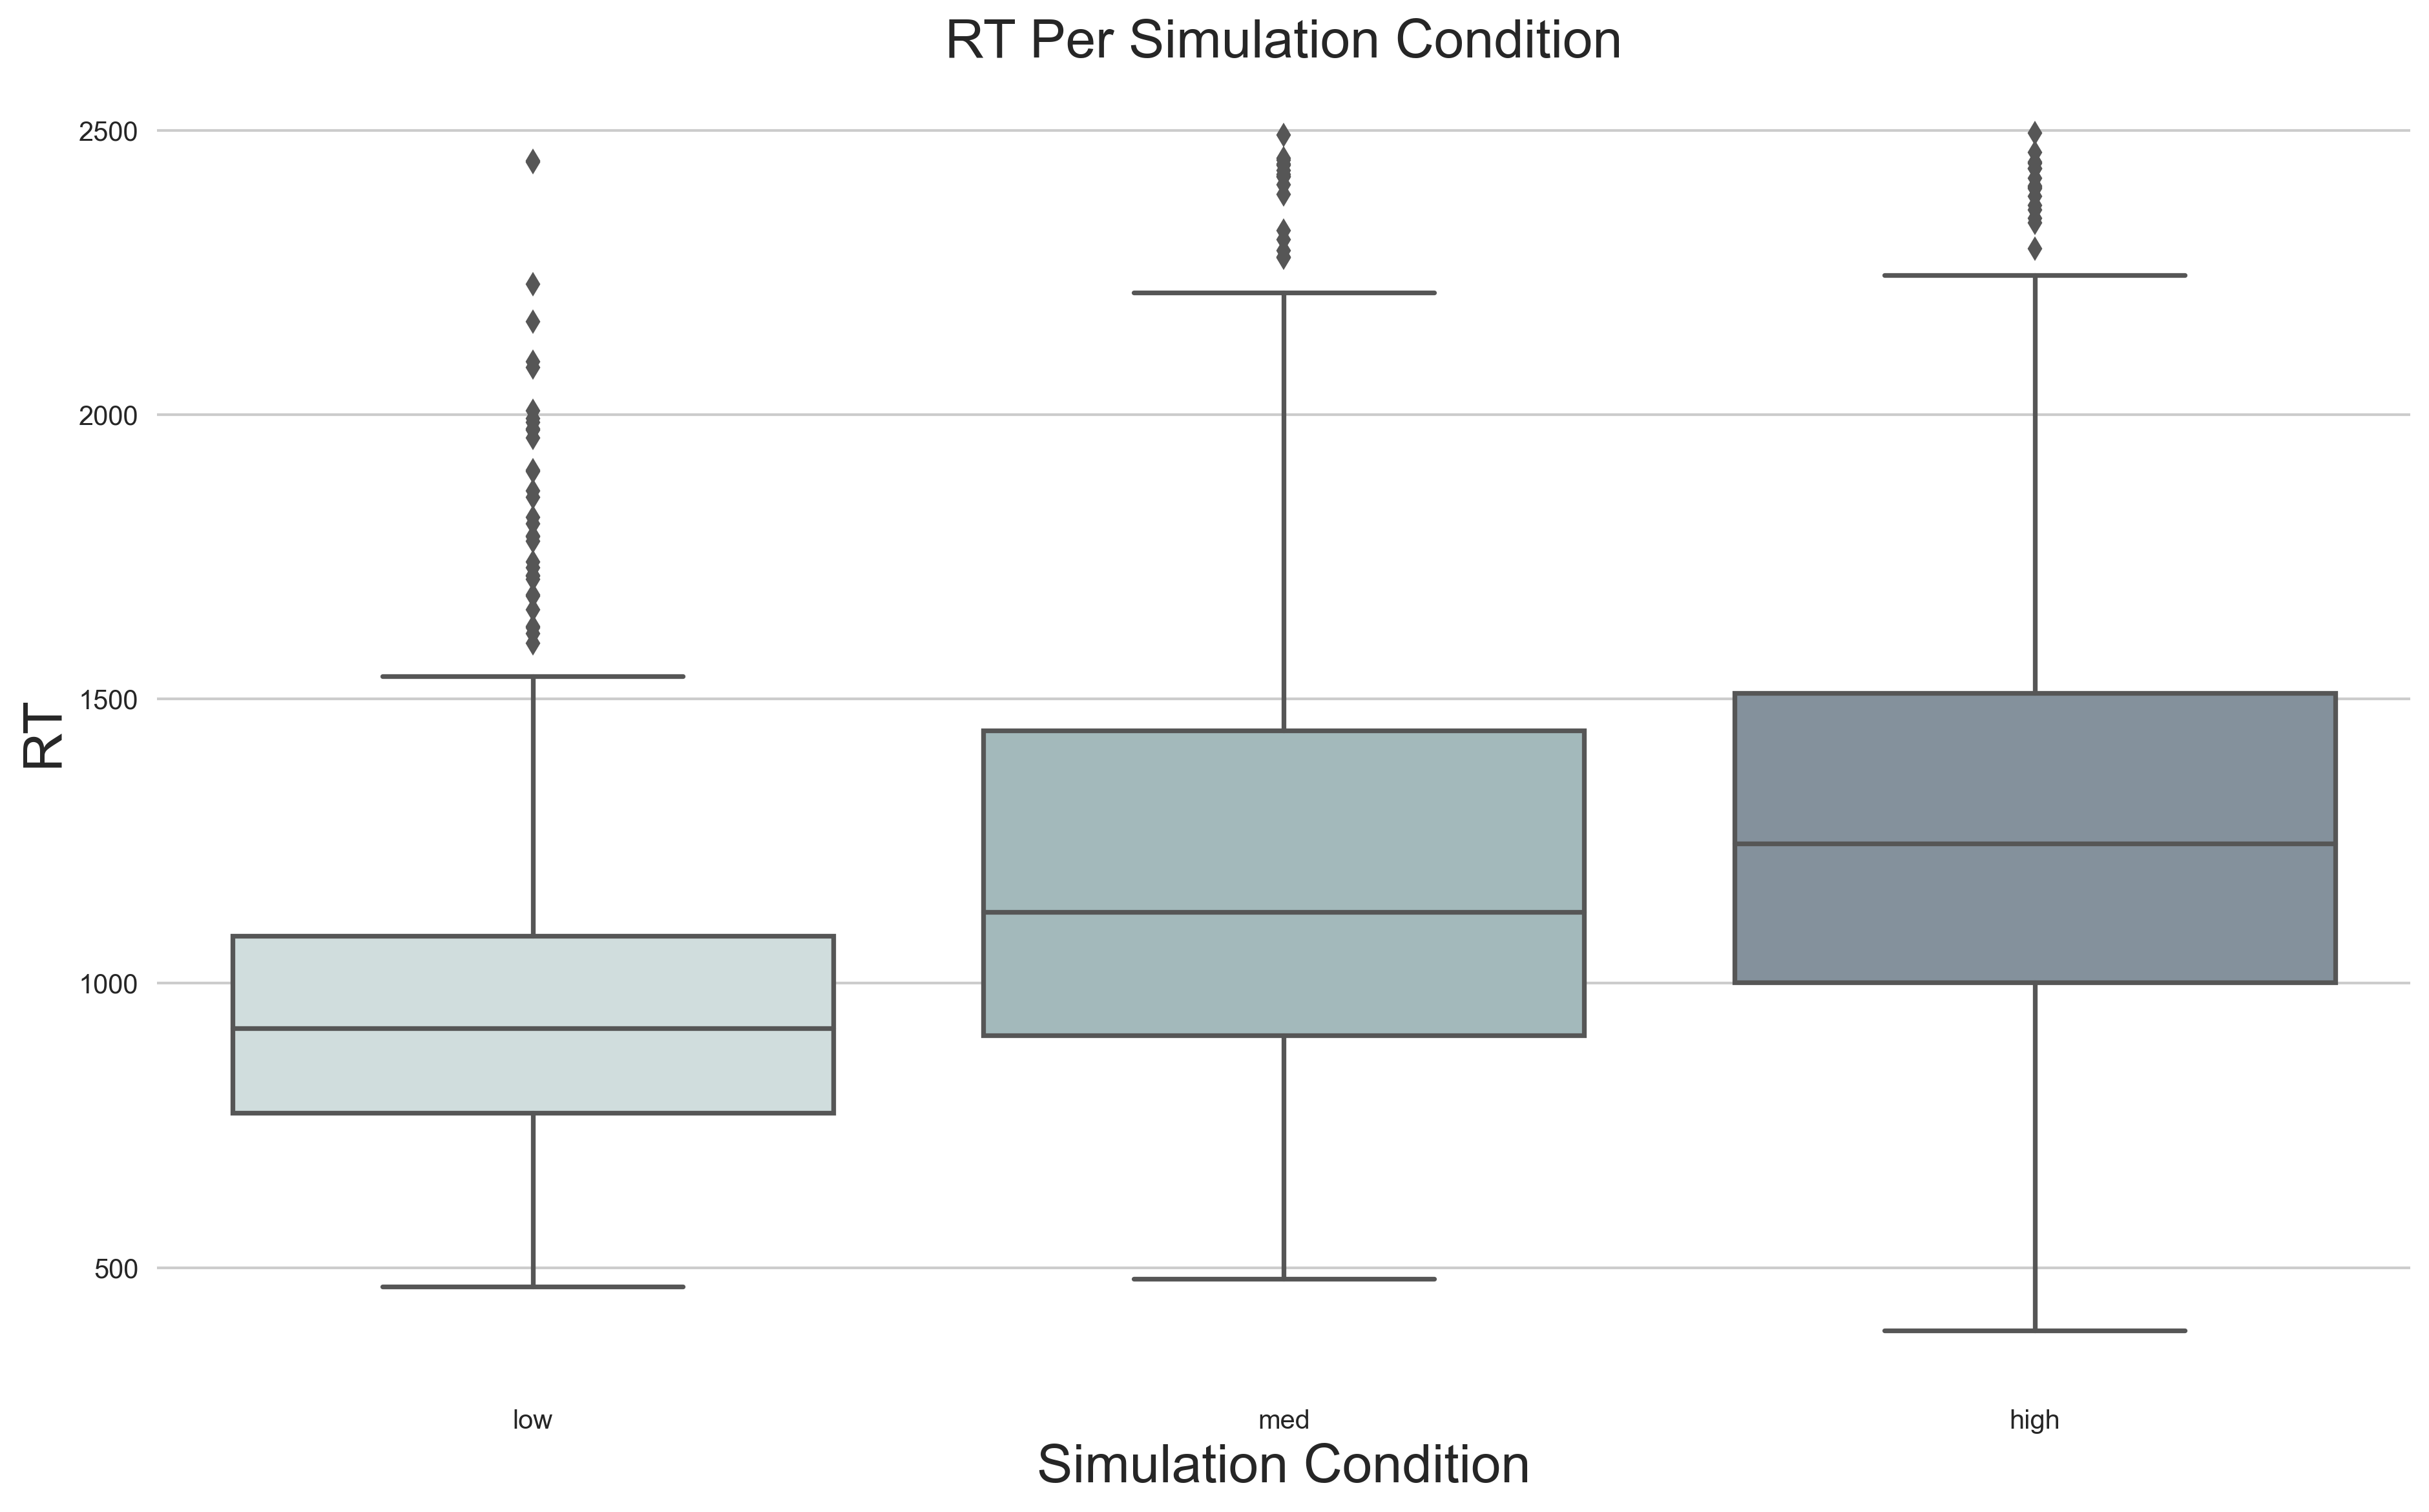

In [16]:
custom_dict = {'low':0, 'med':1,'high':2}
trial=pd.DataFrame(clean_responses.groupby("sim_time").zrt.apply(list))
trial = trial.sort_values(by=['sim_time'],key=lambda x: x.map(custom_dict))

figure(figsize=(15, 9), dpi=300)

# plt.boxplot(trial.zrt)
sns.boxplot(x="sim_time",y="rt",data=clean_responses,order=['low','med','high'])
# plt.xticks(rotation = 90)
plt.title("RT Per Simulation Condition",fontsize=20)
# plt.xticks([1,2,3],[trial.index[0],trial.index[1],trial.index[2]])
plt.xlabel("Simulation Condition",fontsize=20)
plt.ylabel("RT",fontsize=20)
# plt.tight_layout()
plt.show()

### Histogram

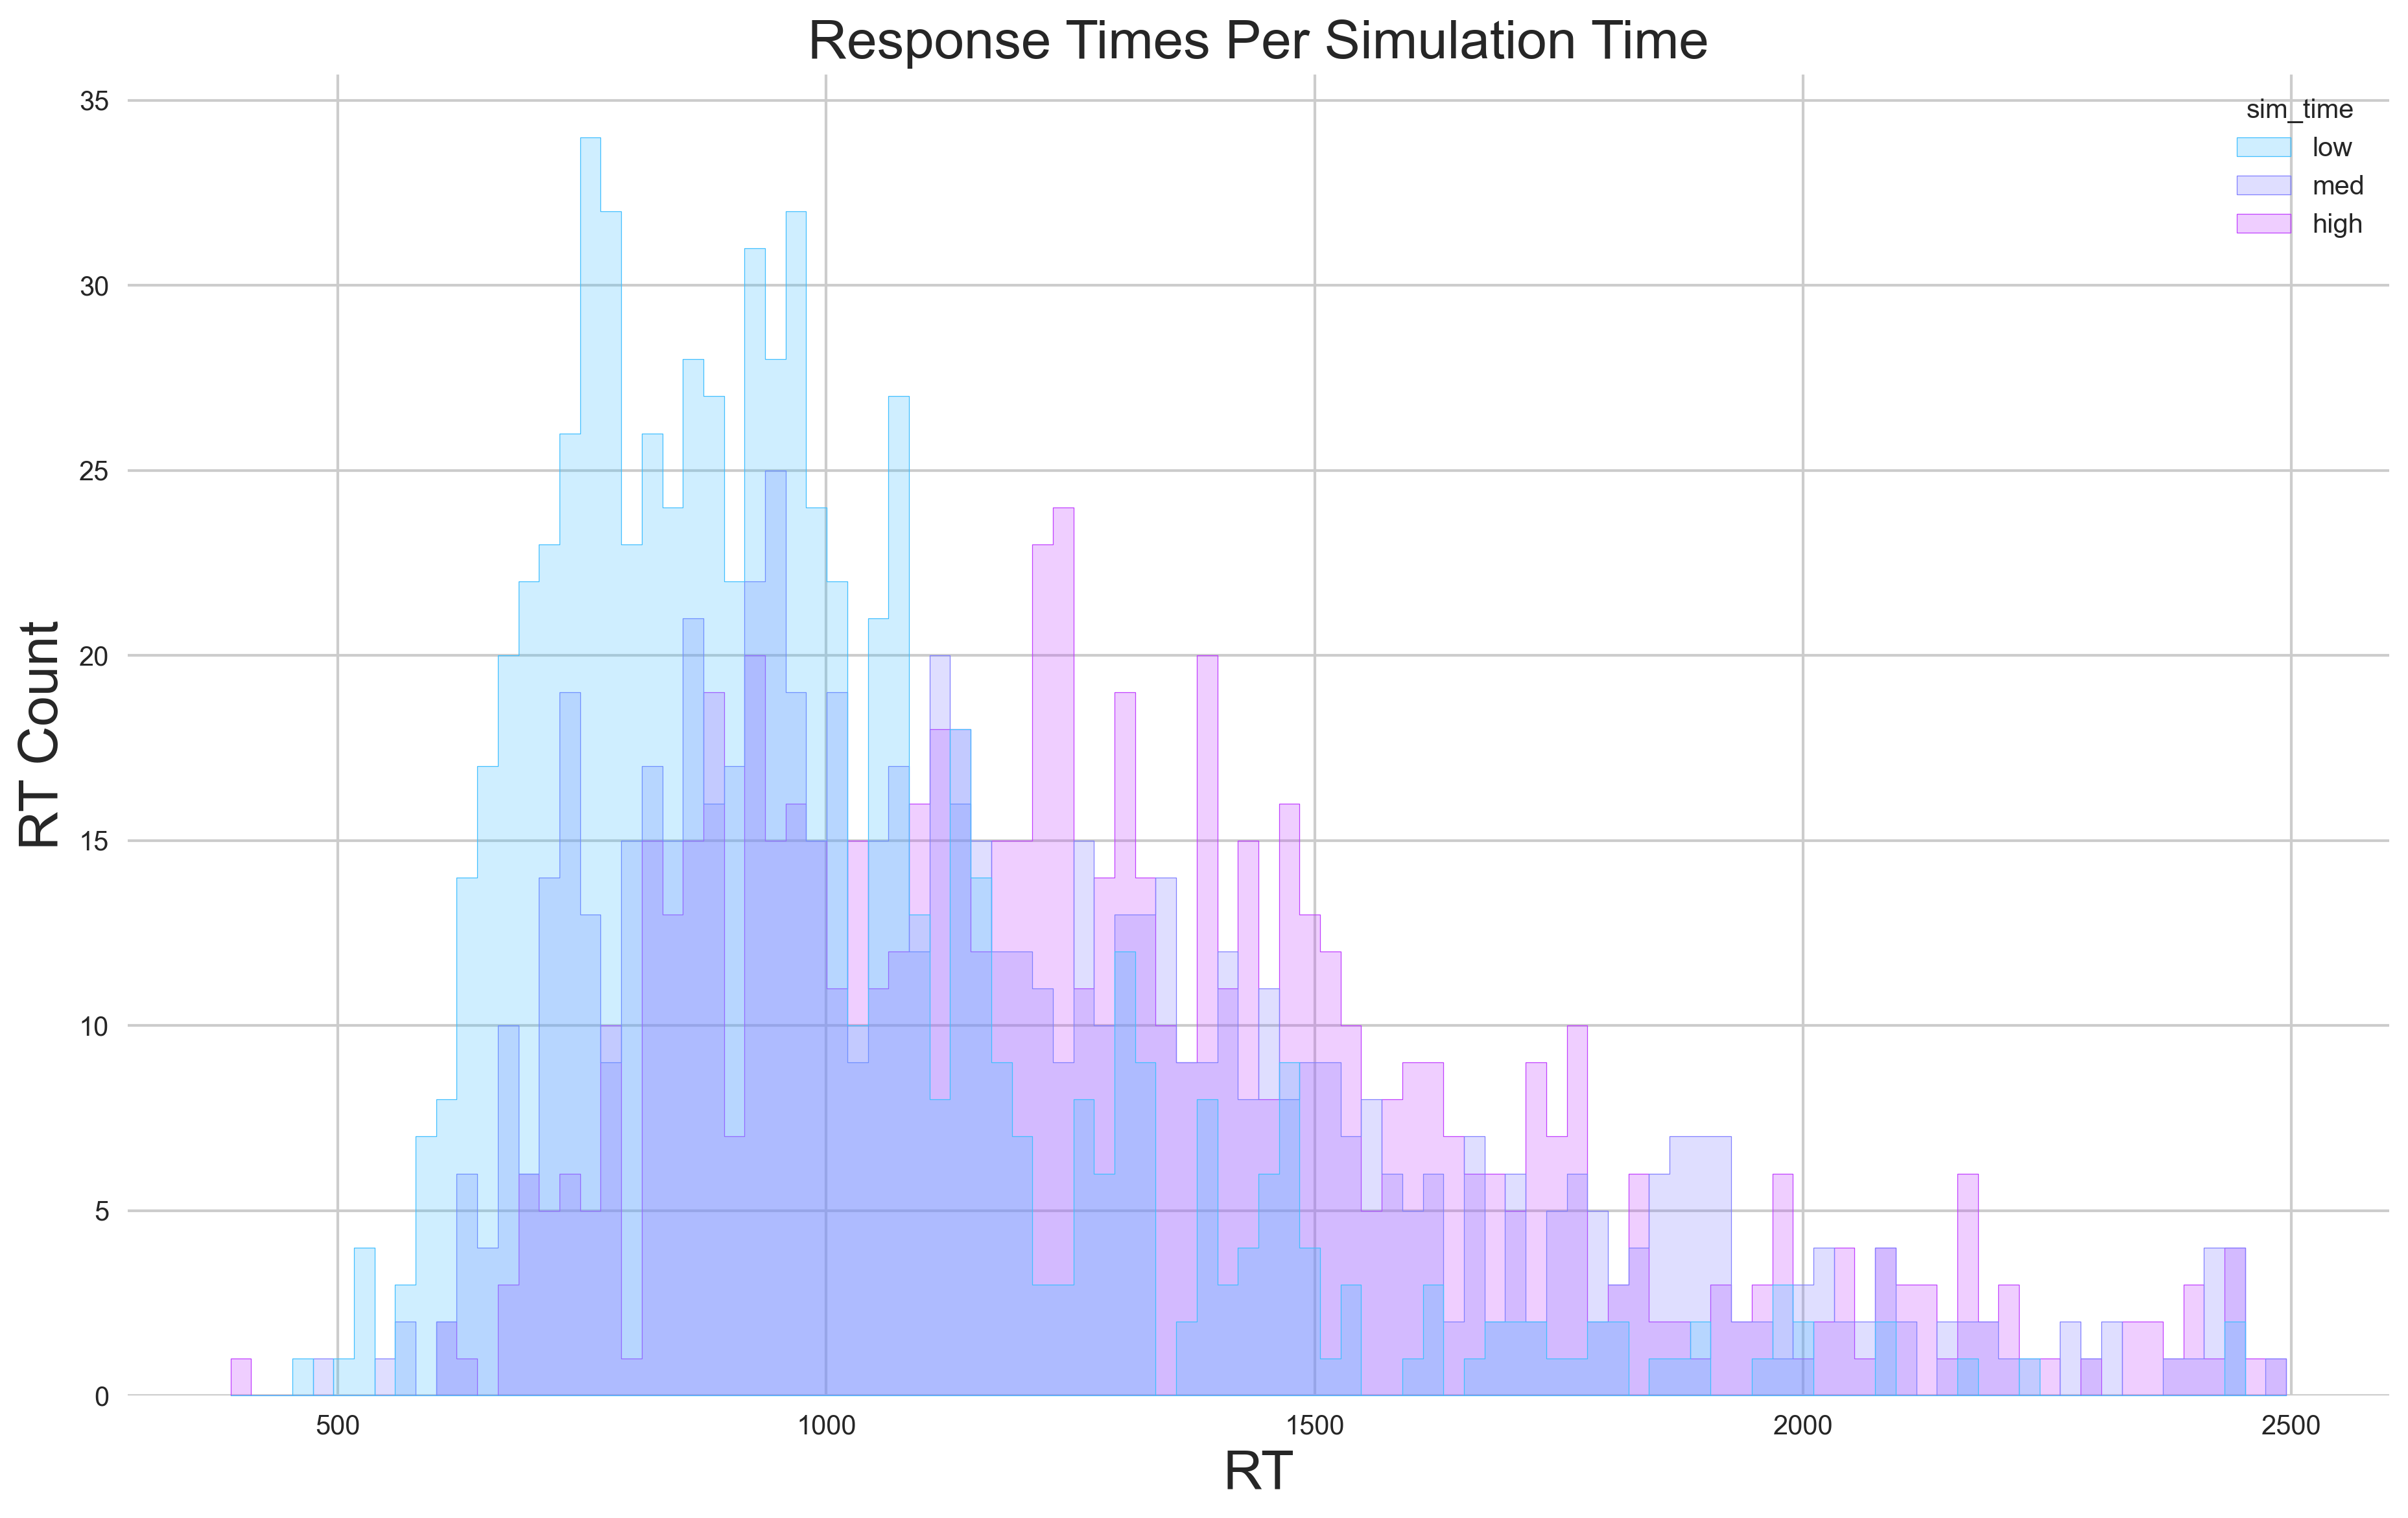

In [17]:
figure(figsize=(15, 9), dpi=300)

sns.histplot(x="rt", data=clean_responses, bins=100,hue="sim_time",element="step",palette="cool");
# sns.histplot(x="rt", data=clean_responses[clean_responses.sim_time=="med"], bins=100, label="Med");
# sns.histplot(x="rt", data=clean_responses[clean_responses.sim_time=="high"], bins=100, label="High");
# plt.hist(clean_responses[clean_responses.sim_time=="high"].rt, bins=100, label="High");
# plt.hist(clean_responses[clean_responses.sim_time=="low"].rt, bins=100, label="Low");
plt.title("Response Times Per Simulation Time",fontsize=20)
plt.xlabel("RT",fontsize=20)
plt.ylabel("RT Count",fontsize=20);
# plt.axvline(clean_responses[clean_responses.sim_time=="low"].rt.mean(),color="red",linestyle='dashed', linewidth=2, label="low Mean: "+str(clean_responses[clean_responses.sim_time=="low"].rt.mean()))
# plt.axvline(clean_responses[clean_responses.sim_time=="med"].rt.mean(),color="blue",linestyle='dashed', linewidth=2, label="med Mean: "+str(clean_responses[clean_responses.sim_time=="med"].rt.mean()))
# plt.axvline(clean_responses[clean_responses.sim_time=="high"].rt.mean(),color="green",linestyle='dashed', linewidth=2, label="high Mean: "+str(clean_responses[clean_responses.sim_time=="high"].rt.mean()))
# plt.legend(loc="upper left")

### Statistical Tests for Difference (Mann-Whitney U Test and Shapiro Test)
Determining whether RT is normally distributed and whether there is difference across the RT according to simulation time condition

#### Conclusions:
RT is not normally distributed in any grouping according to simulation time (p < 3e-23)

There exists statistical differences (Mann-Whitney U) between each grouping of RT: 
- **Low < Med** p = 5e-35
- **Med < High** p = 2e-07
- **Low < High** p = 5e-70

In [18]:
from scipy.stats import ttest_ind,mannwhitneyu,shapiro

low = list(clean_responses[(clean_responses["sim_time"]=="low")].rt)
med = list(clean_responses[(clean_responses["sim_time"]=="med")].rt)
high = list(clean_responses[(clean_responses["sim_time"]=="high")].rt)

shap_low = shapiro(low)
shap_med = shapiro(med)
shap_high = shapiro(high)

print(f"Low Shapiro: {shap_low}. Data is {'not' if shap_low.pvalue < 0.05 else ''} normal.")
print(f"Med Shapiro: {shap_med}. Data is {'not' if shap_med.pvalue < 0.05 else ''} normal.")
print(f"High Shapiro: {shap_high}. Data is {'not' if shap_high.pvalue < 0.05 else ''} normal.")
print("")

u_res = mannwhitneyu(low, med, alternative="less")
u_res_mh = mannwhitneyu(med, high, alternative="less")
u_res_lh = mannwhitneyu(low, high, alternative="less")

print(f"Low-Med T test statistic: {u_res}")
print(f"Med-High U test statistic: {u_res_mh}")
print(f"Low-High U test statistic: {u_res_lh}")

Low Shapiro: ShapiroResult(statistic=0.8828297257423401, pvalue=3.343152442192663e-23). Data is not normal.
Med Shapiro: ShapiroResult(statistic=0.937088668346405, pvalue=6.795812172014746e-17). Data is not normal.
High Shapiro: ShapiroResult(statistic=0.9564344882965088, pvalue=1.2976112426319603e-13). Data is not normal.

Low-Med T test statistic: MannwhitneyuResult(statistic=167941.5, pvalue=5.061632205581014e-35)
Med-High U test statistic: MannwhitneyuResult(statistic=215554.0, pvalue=2.2590107803022203e-07)
Low-High U test statistic: MannwhitneyuResult(statistic=121151.5, pvalue=5.339284730498571e-70)


### Comparing Straight Paths and Non-straight Paths

In [23]:
spdata = clean_responses[clean_responses['scene_sp']=='yes']
nospdata = clean_responses[clean_responses['scene_sp']=='no']

#### Testing difference in RT across all Simulation Time conditions

In [26]:
# SP v NoSP
sp = list(spdata.rt)
nosp = list(nospdata.rt)
u_res = mannwhitneyu(sp, nosp, alternative="less")
print(f"U test statistic: {u_res}")

U test statistic: MannwhitneyuResult(statistic=356006.0, pvalue=5.18591015222328e-57)


#### Testing difference in RT per each Simulation Time condition

In [29]:
# SP v NoSP Across Sim Times

# Low
splow = list(spdata[spdata['sim_time']=='low'].rt)
nosplow = list(nospdata[nospdata['sim_time']=='low'].rt)
u_res = mannwhitneyu(splow, nosplow, alternative="less")
print(f"U test statistic for Low-SP v Low-NoSP: {u_res}")

# Med
spmed = list(spdata[spdata['sim_time']=='med'].rt)
nospmed = list(nospdata[nospdata['sim_time']=='med'].rt)
u_res = mannwhitneyu(spmed, nospmed, alternative="less")
print(f"U test statistic for Med-SP v Med-NoSP: {u_res}")

# High
sphigh = list(spdata[spdata['sim_time']=='high'].rt)
nosphigh = list(nospdata[nospdata['sim_time']=='high'].rt)
u_res = mannwhitneyu(sphigh, nosphigh, alternative="less")
print(f"U test statistic for High-SP v High-NoSP: {u_res}")

U test statistic for Low-SP v Low-NoSP: MannwhitneyuResult(statistic=41308.0, pvalue=5.0489268108940725e-21)
U test statistic for Med-SP v Med-NoSP: MannwhitneyuResult(statistic=31837.5, pvalue=8.194154010199086e-33)
U test statistic for High-SP v High-NoSP: MannwhitneyuResult(statistic=35803.0, pvalue=8.6837569977923e-23)


In [33]:
# Difference across simulation time conditions within SP condition
splow = list(spdata[spdata['sim_time']=='low'].rt)
spmed = list(spdata[spdata['sim_time']=='med'].rt)
sphigh = list(spdata[spdata['sim_time']=='high'].rt)

u_res = mannwhitneyu(splow, spmed, alternative="less")
print(f"U test statistic for Low-SP v Med-SP: {u_res}")
u_res = mannwhitneyu(spmed, sphigh, alternative="less")
print(f"U test statistic for Med-SP v High-SP: {u_res}")
u_res = mannwhitneyu(splow, sphigh, alternative="less")
print(f"U test statistic for Low-SP v High-SP: {u_res}")

U test statistic for Low-SP v Med-SP: MannwhitneyuResult(statistic=45428.0, pvalue=3.817807993003775e-16)
U test statistic for Med-SP v High-SP: MannwhitneyuResult(statistic=50557.5, pvalue=5.280623518042319e-10)
U test statistic for Low-SP v High-SP: MannwhitneyuResult(statistic=28442.0, pvalue=1.608242567231923e-42)


In [41]:
# Difference across simulation time conditions within SP condition
nosplow = list(nospdata[nospdata['sim_time']=='low'].rt)
nospmed = list(nospdata[nospdata['sim_time']=='med'].rt)
nosphigh = list(nospdata[nospdata['sim_time']=='high'].rt)

u_res = mannwhitneyu(nosplow, nospmed, alternative="less")
print(f"U test statistic for Low-NoSP v Med-NoSP: {u_res}")
u_res = mannwhitneyu(nospmed, nosphigh, alternative="less")
print(f"U test statistic for Med-NoSP v High-NoSP: {u_res}")
u_res = mannwhitneyu(nosplow, nosphigh, alternative="less")
print(f"U test statistic for Low-NoSP v High-NoSP: {u_res}")

U test statistic for Low-NoSP v Med-NoSP: MannwhitneyuResult(statistic=33228.0, pvalue=1.0572356840772566e-29)
U test statistic for Med-NoSP v High-NoSP: MannwhitneyuResult(statistic=54385.5, pvalue=0.02919561693932)
U test statistic for Low-NoSP v High-NoSP: MannwhitneyuResult(statistic=26771.5, pvalue=2.826898679691252e-40)


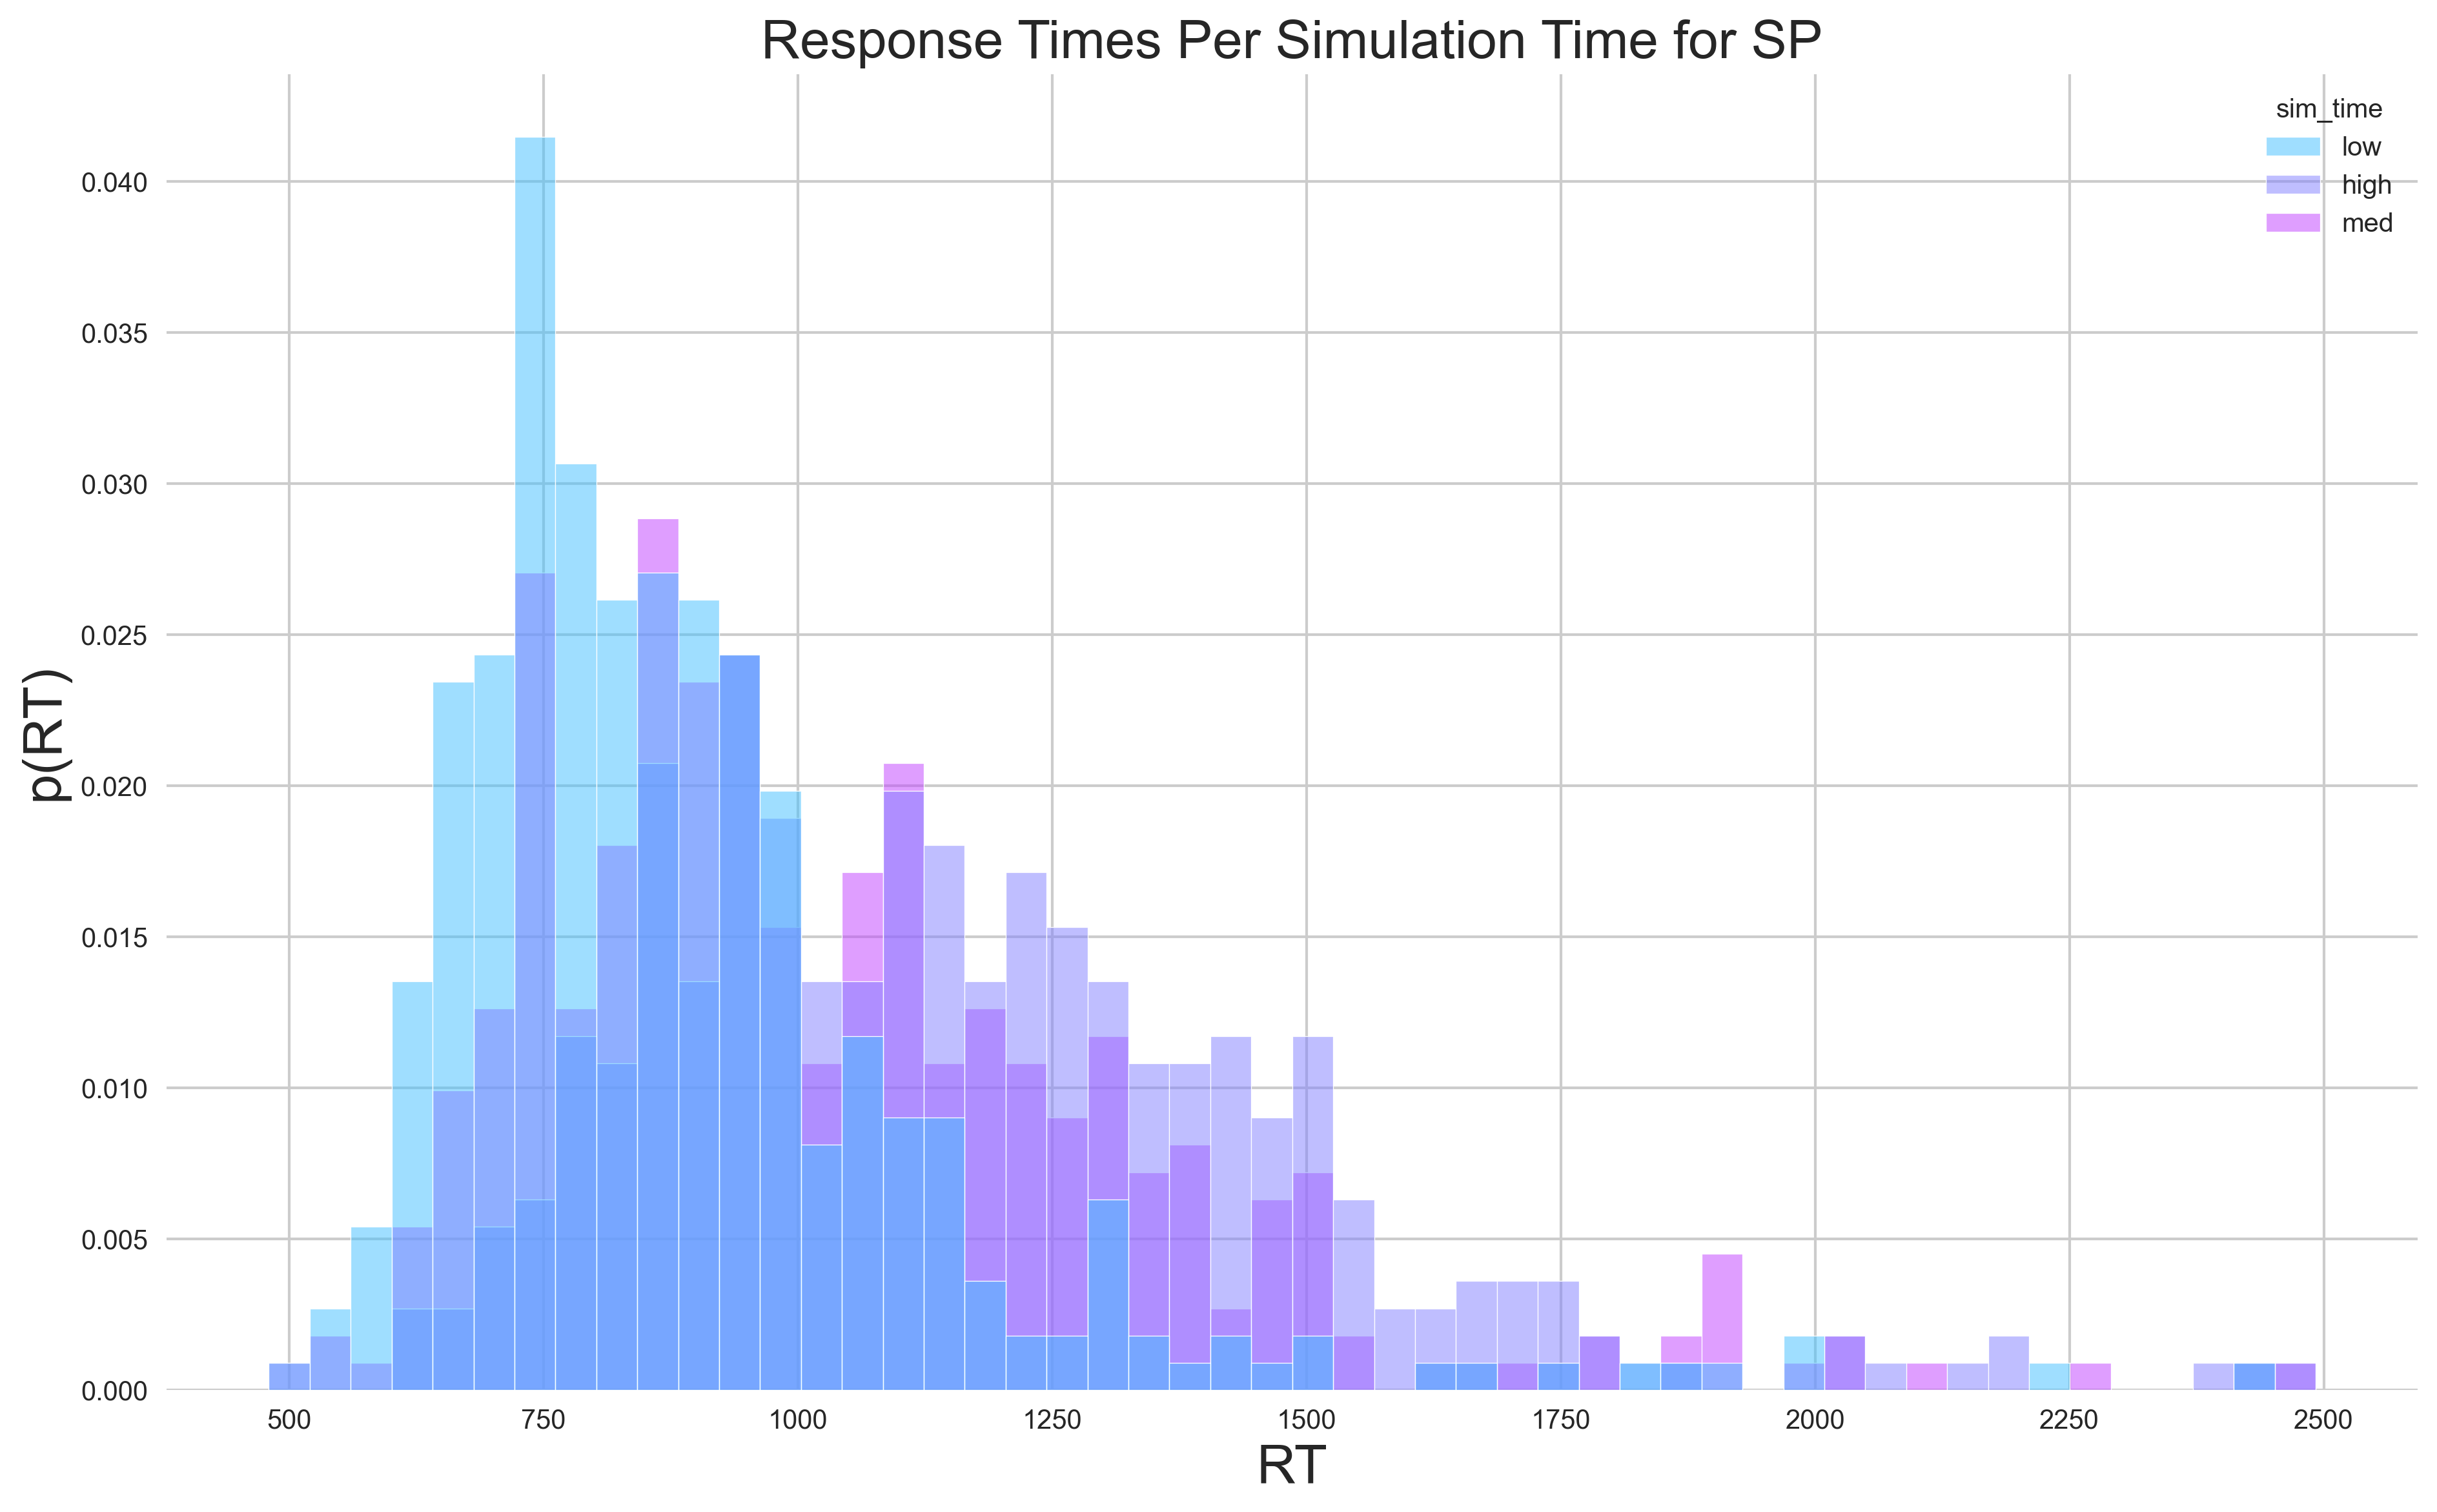

In [35]:
figure(figsize=(15, 9), dpi=300)
sns.histplot(x="rt",data=spdata,hue="sim_time",bins=50,stat="probability",palette="cool")
plt.title("Response Times Per Simulation Time for SP",fontsize=20)
plt.xlabel("RT",fontsize=20)
plt.ylabel("p(RT)",fontsize=20);

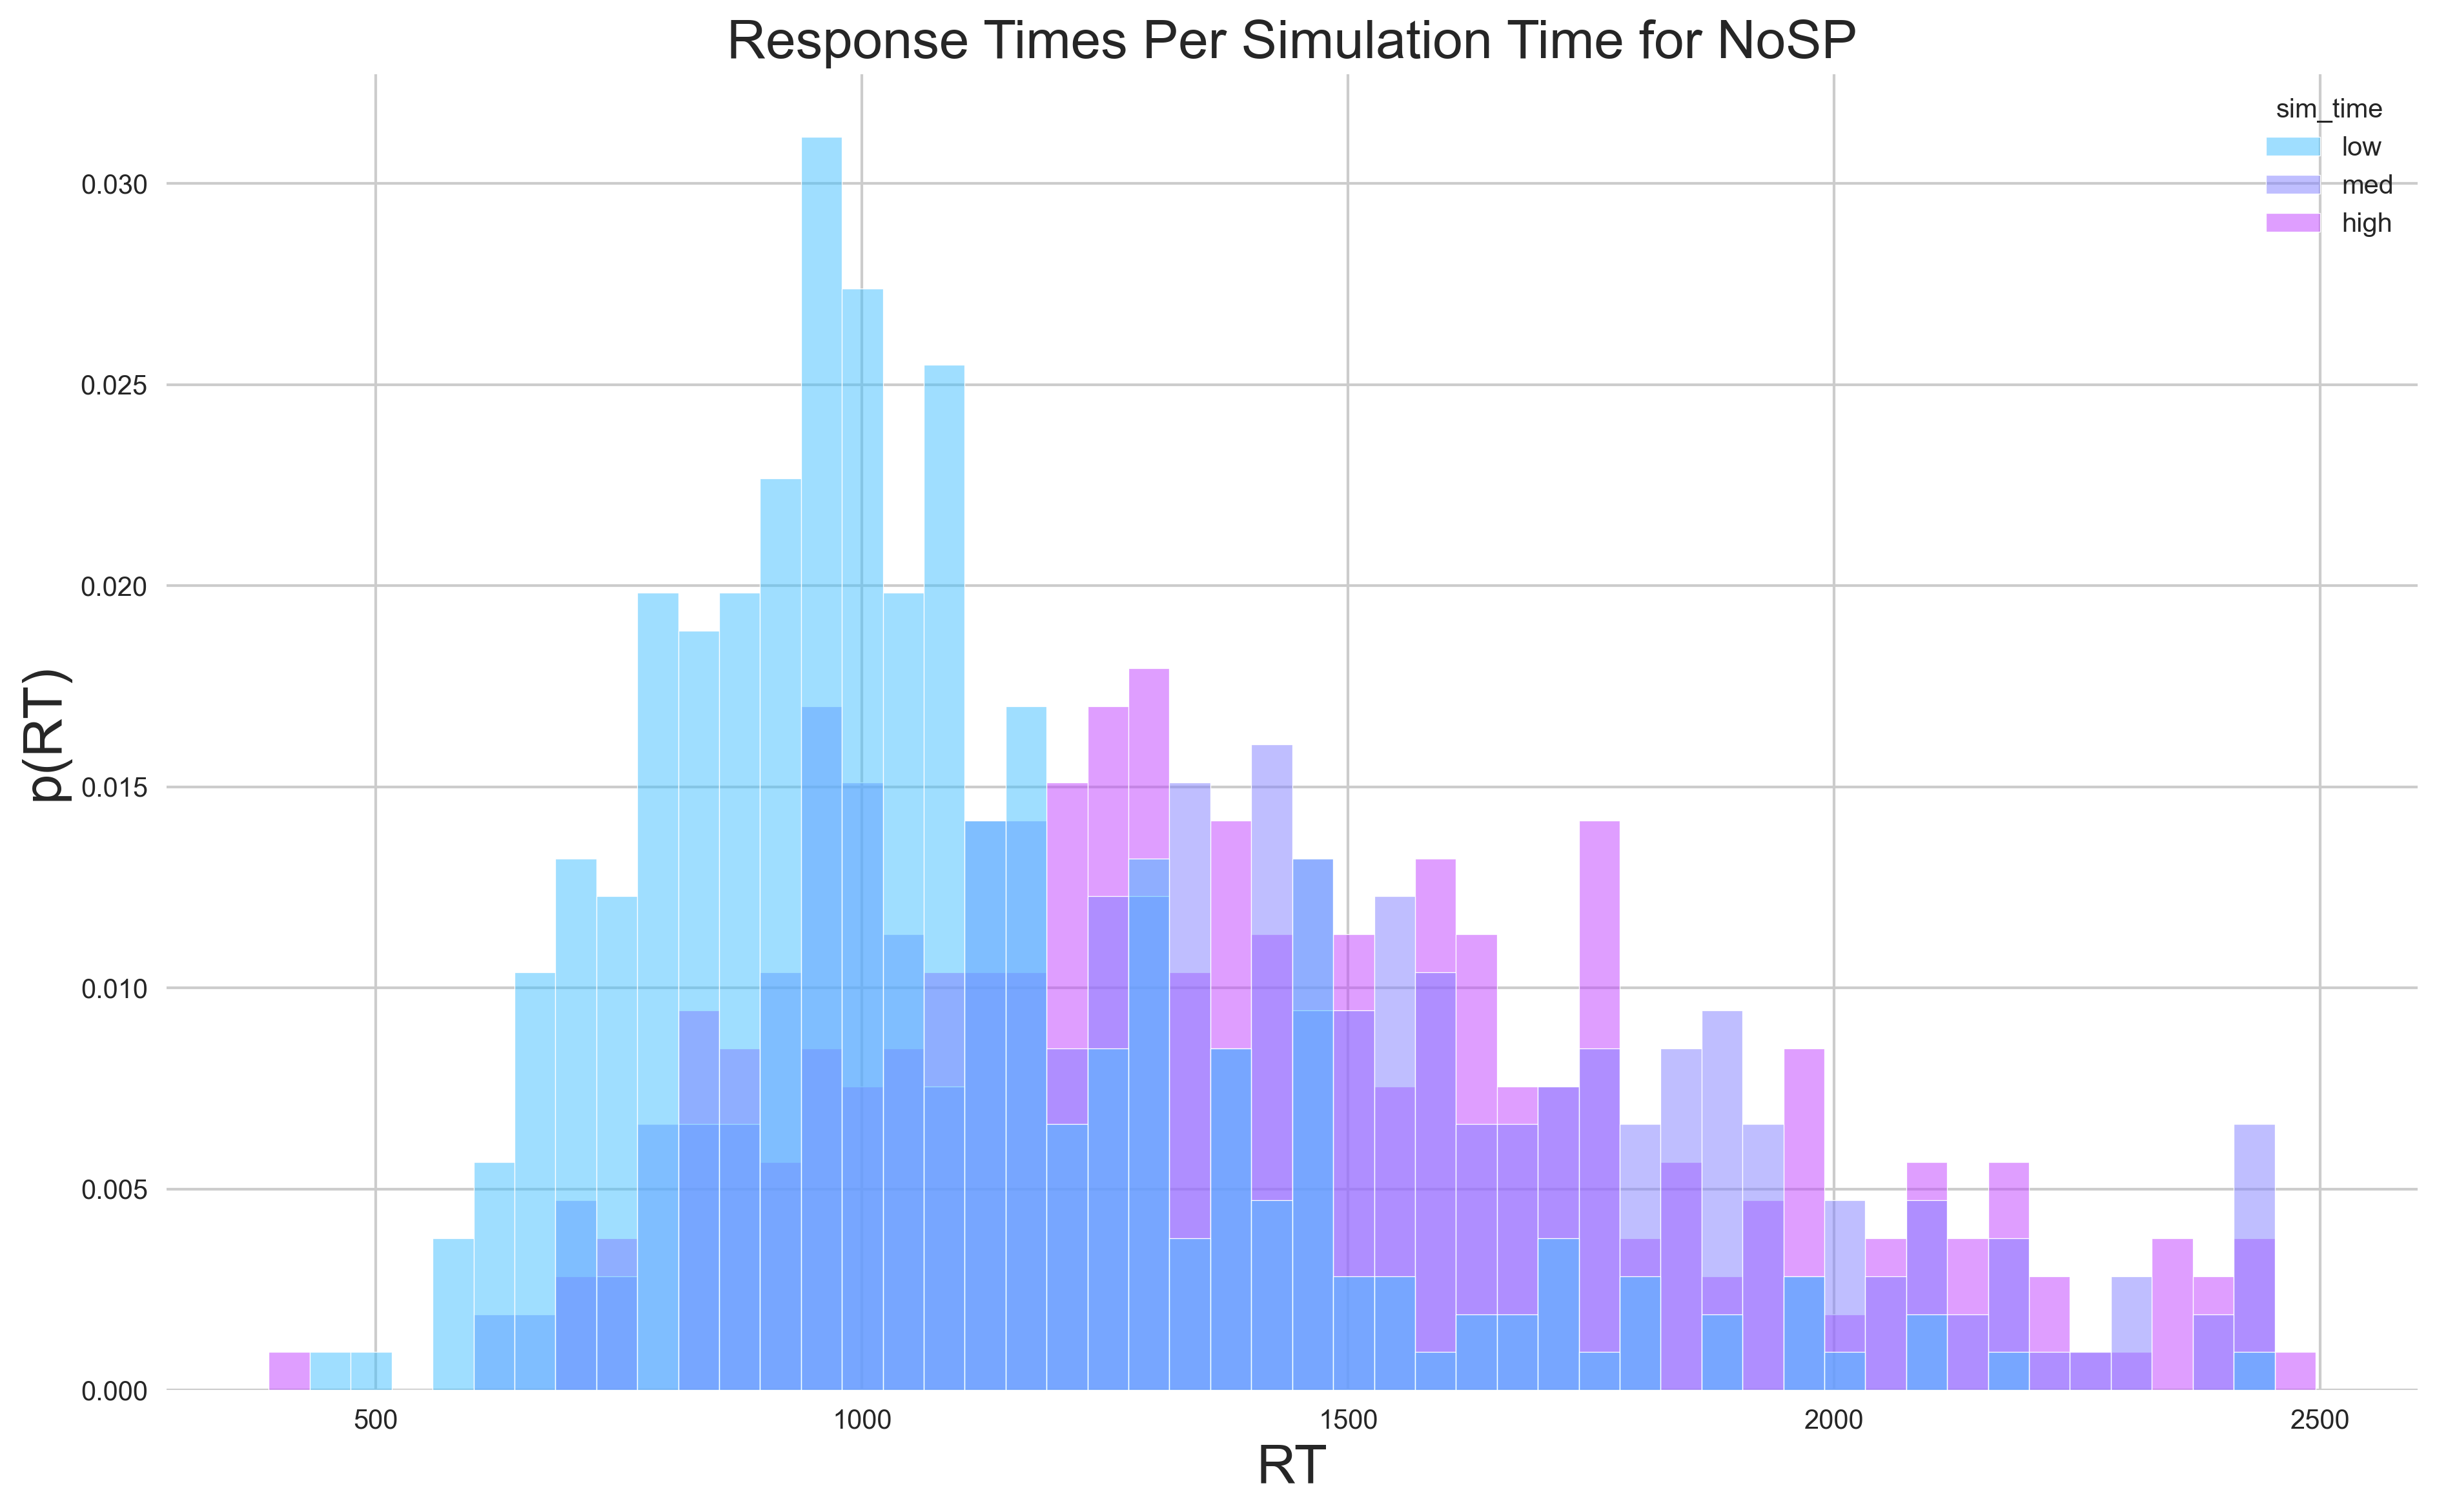

In [36]:
figure(figsize=(15, 9), dpi=300)
sns.histplot(x="rt",data=nospdata,hue="sim_time",bins=50,stat="probability",palette="cool")
plt.title("Response Times Per Simulation Time for NoSP",fontsize=20)
plt.xlabel("RT",fontsize=20)
plt.ylabel("p(RT)",fontsize=20);

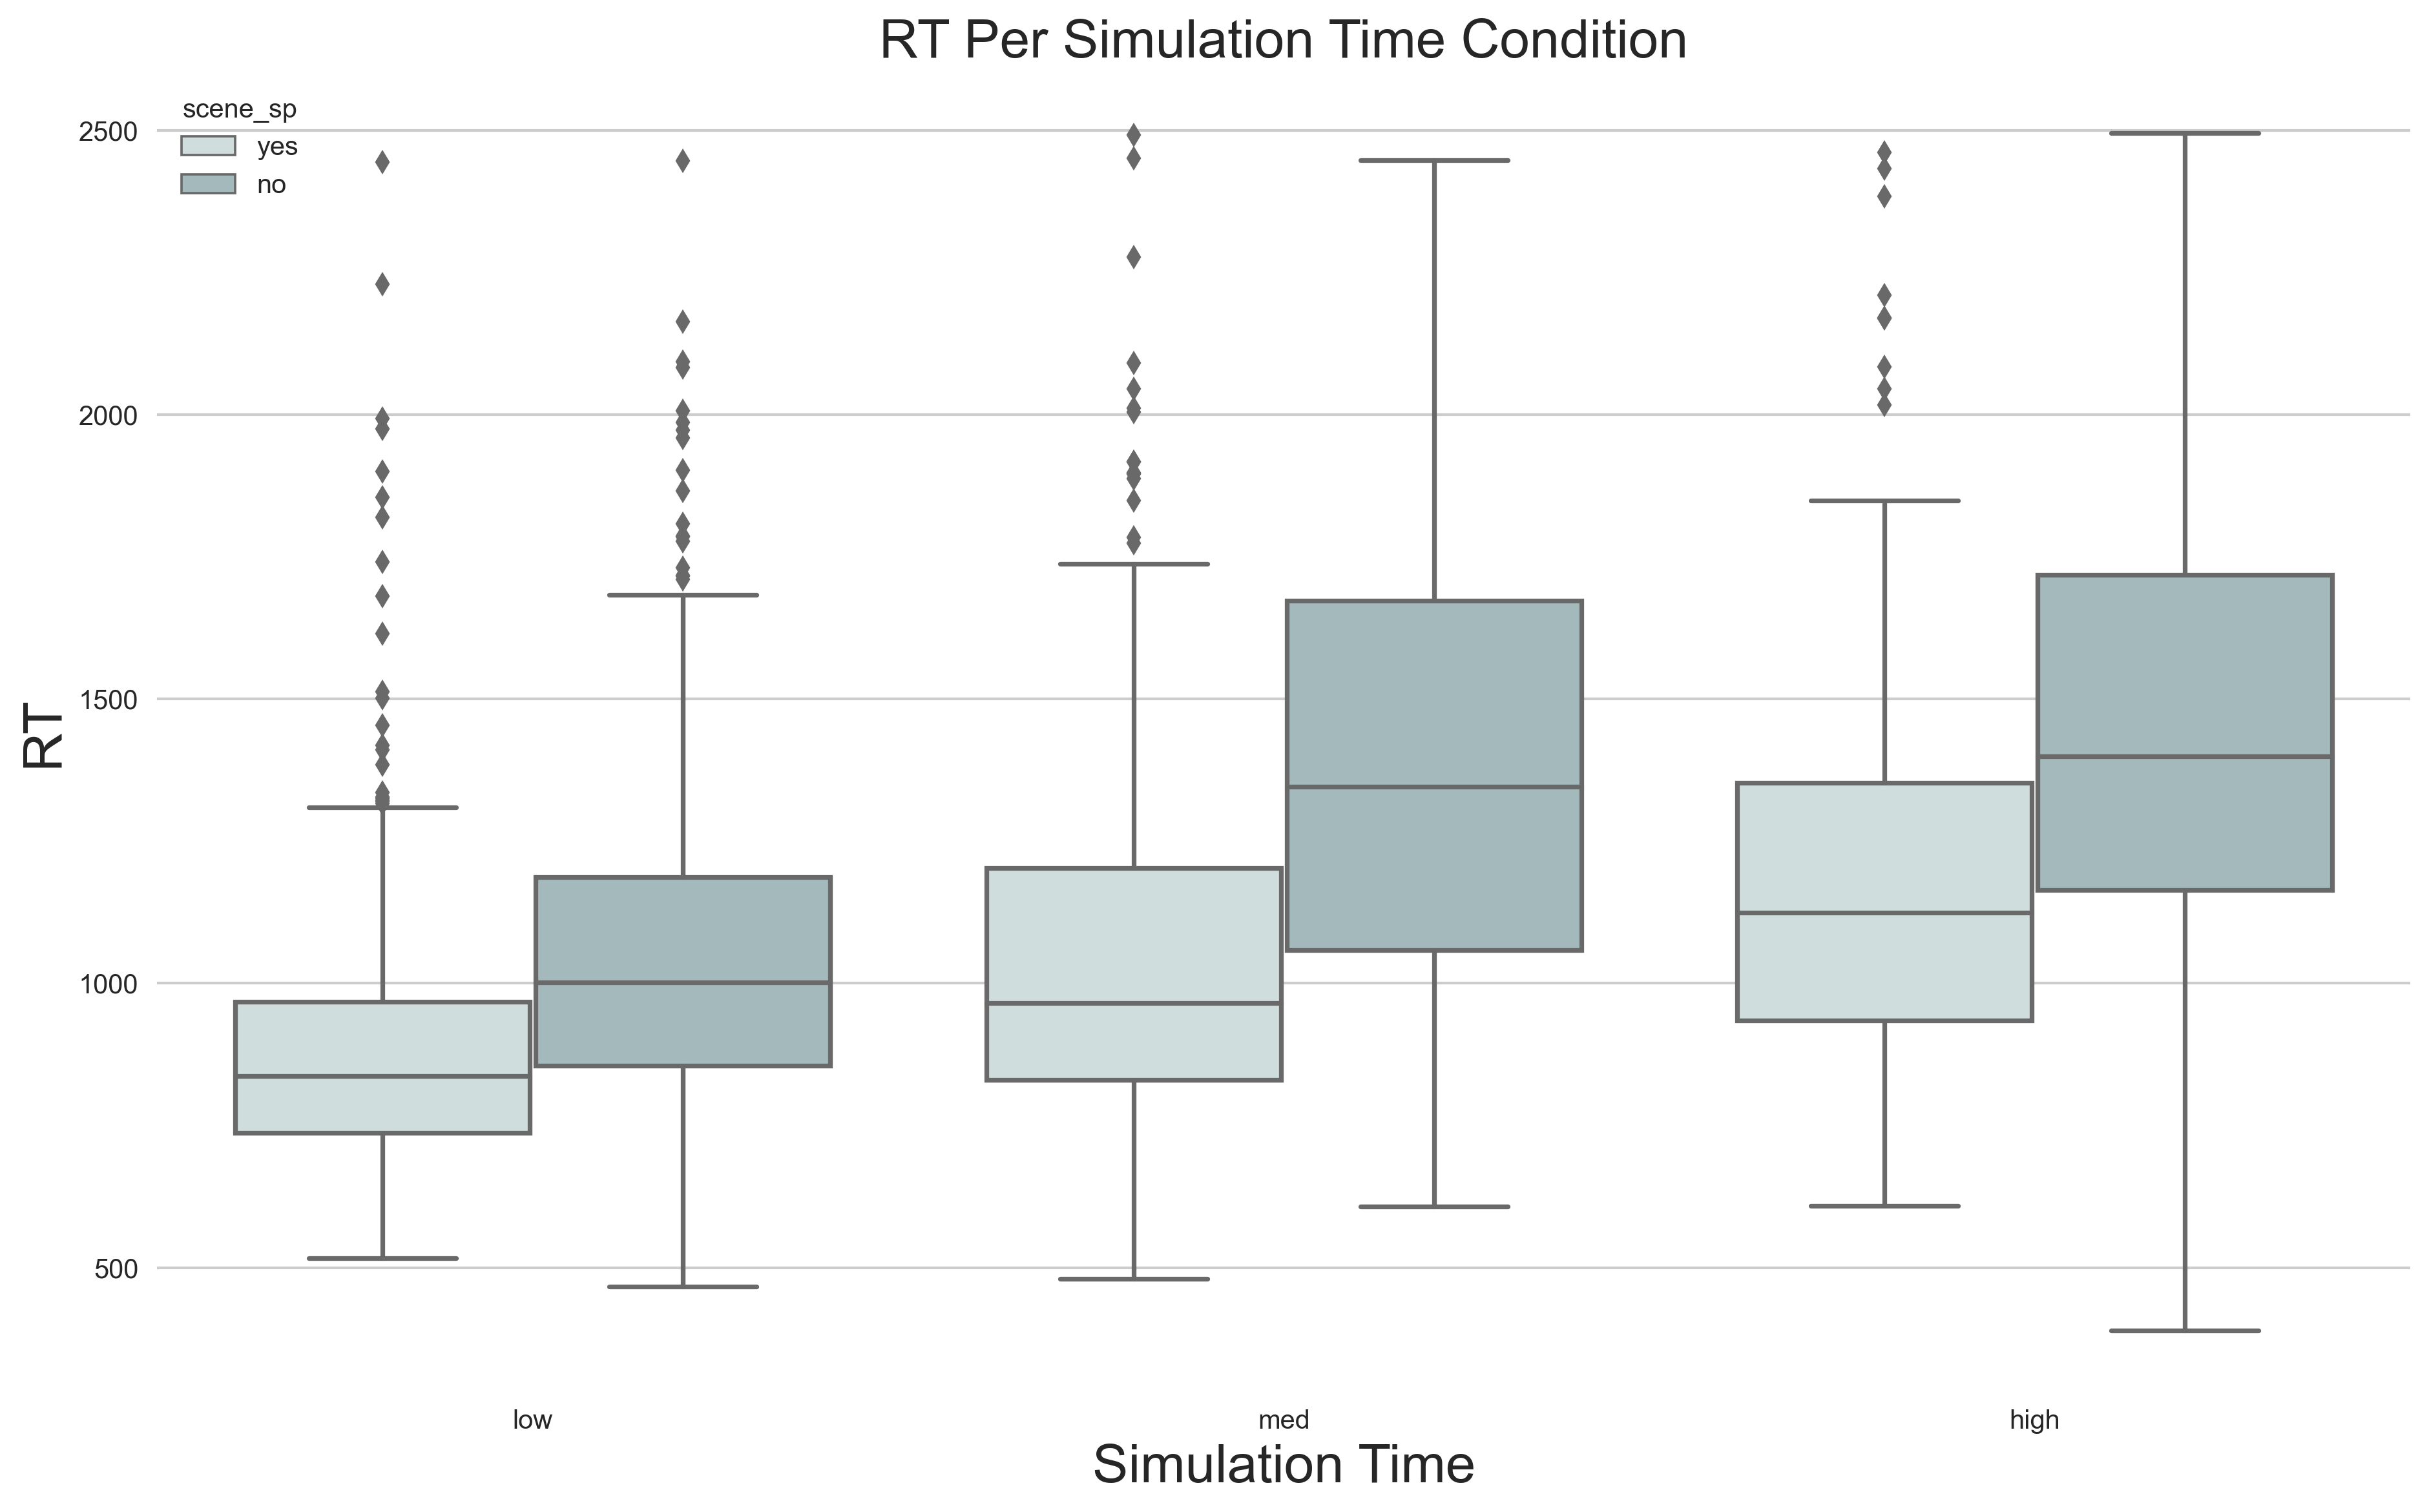

In [40]:
figure(figsize=(15, 9), dpi=300)
# sns.boxplot(y="rt",x="sim_time",data=spdata)
sns.boxplot(y='rt', x="sim_time",data=clean_responses,order=['low','med','high'],hue="scene_sp")
plt.title("RT Per Simulation Time Condition",fontsize=20)
plt.xlabel("Simulation Time",fontsize=20)
plt.ylabel("RT",fontsize=20)
plt.show()

## Calculating Empirical 95% CI

In [539]:
low = list(clean_responses[(clean_responses["sim_time"]=="low")].rt)
med = list(clean_responses[(clean_responses["sim_time"]=="med")].rt)
high = list(clean_responses[(clean_responses["sim_time"]=="high")].rt)

def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

low_bs_samples = draw_bs_replicates(low,np.mean,1000)
med_bs_samples = draw_bs_replicates(med,np.mean,1000)
high_bs_samples = draw_bs_replicates(high,np.mean,1000)

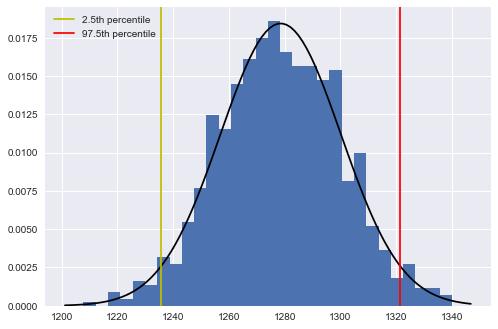

In [543]:
from scipy.stats import norm

# Plot the PDF for bootstrap replicates as histogram
plt.hist(low_bs_samples,bins=30,density=True)

mu, std = np.mean(low_bs_samples), np.std(low_bs_samples)
xmin, xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = norm.pdf(x,mu,std)

plt.plot(x,p,'k')

# Showing the related percentiles
plt.axvline(x=np.percentile(low_bs_samples,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(low_bs_samples,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.legend()

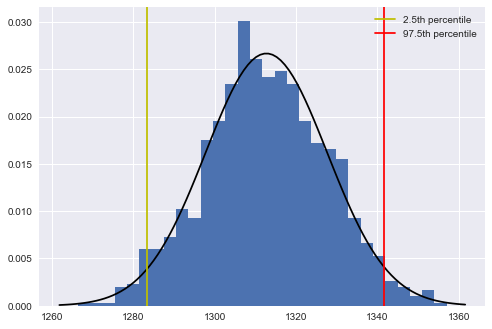

In [545]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(med_bs_samples,bins=30,density=True)

mu, std = np.mean(med_bs_samples), np.std(med_bs_samples)
xmin, xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = norm.pdf(x,mu,std)

plt.plot(x,p,'k')

# Showing the related percentiles
plt.axvline(x=np.percentile(med_bs_samples,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(med_bs_samples,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.legend()

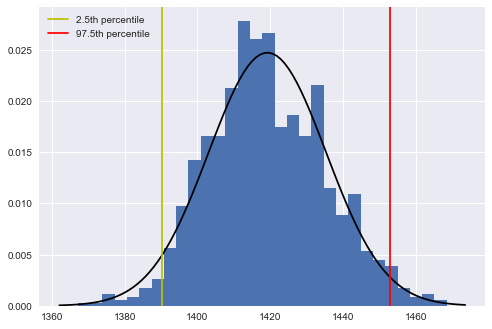

In [546]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(high_bs_samples,bins=30,density=True)

mu, std = np.mean(high_bs_samples), np.std(high_bs_samples)
xmin, xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = norm.pdf(x,mu,std)

plt.plot(x,p,'k')

# Showing the related percentiles
plt.axvline(x=np.percentile(high_bs_samples,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(high_bs_samples,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.legend()

Text(0, 0.5, 'P(RT)')

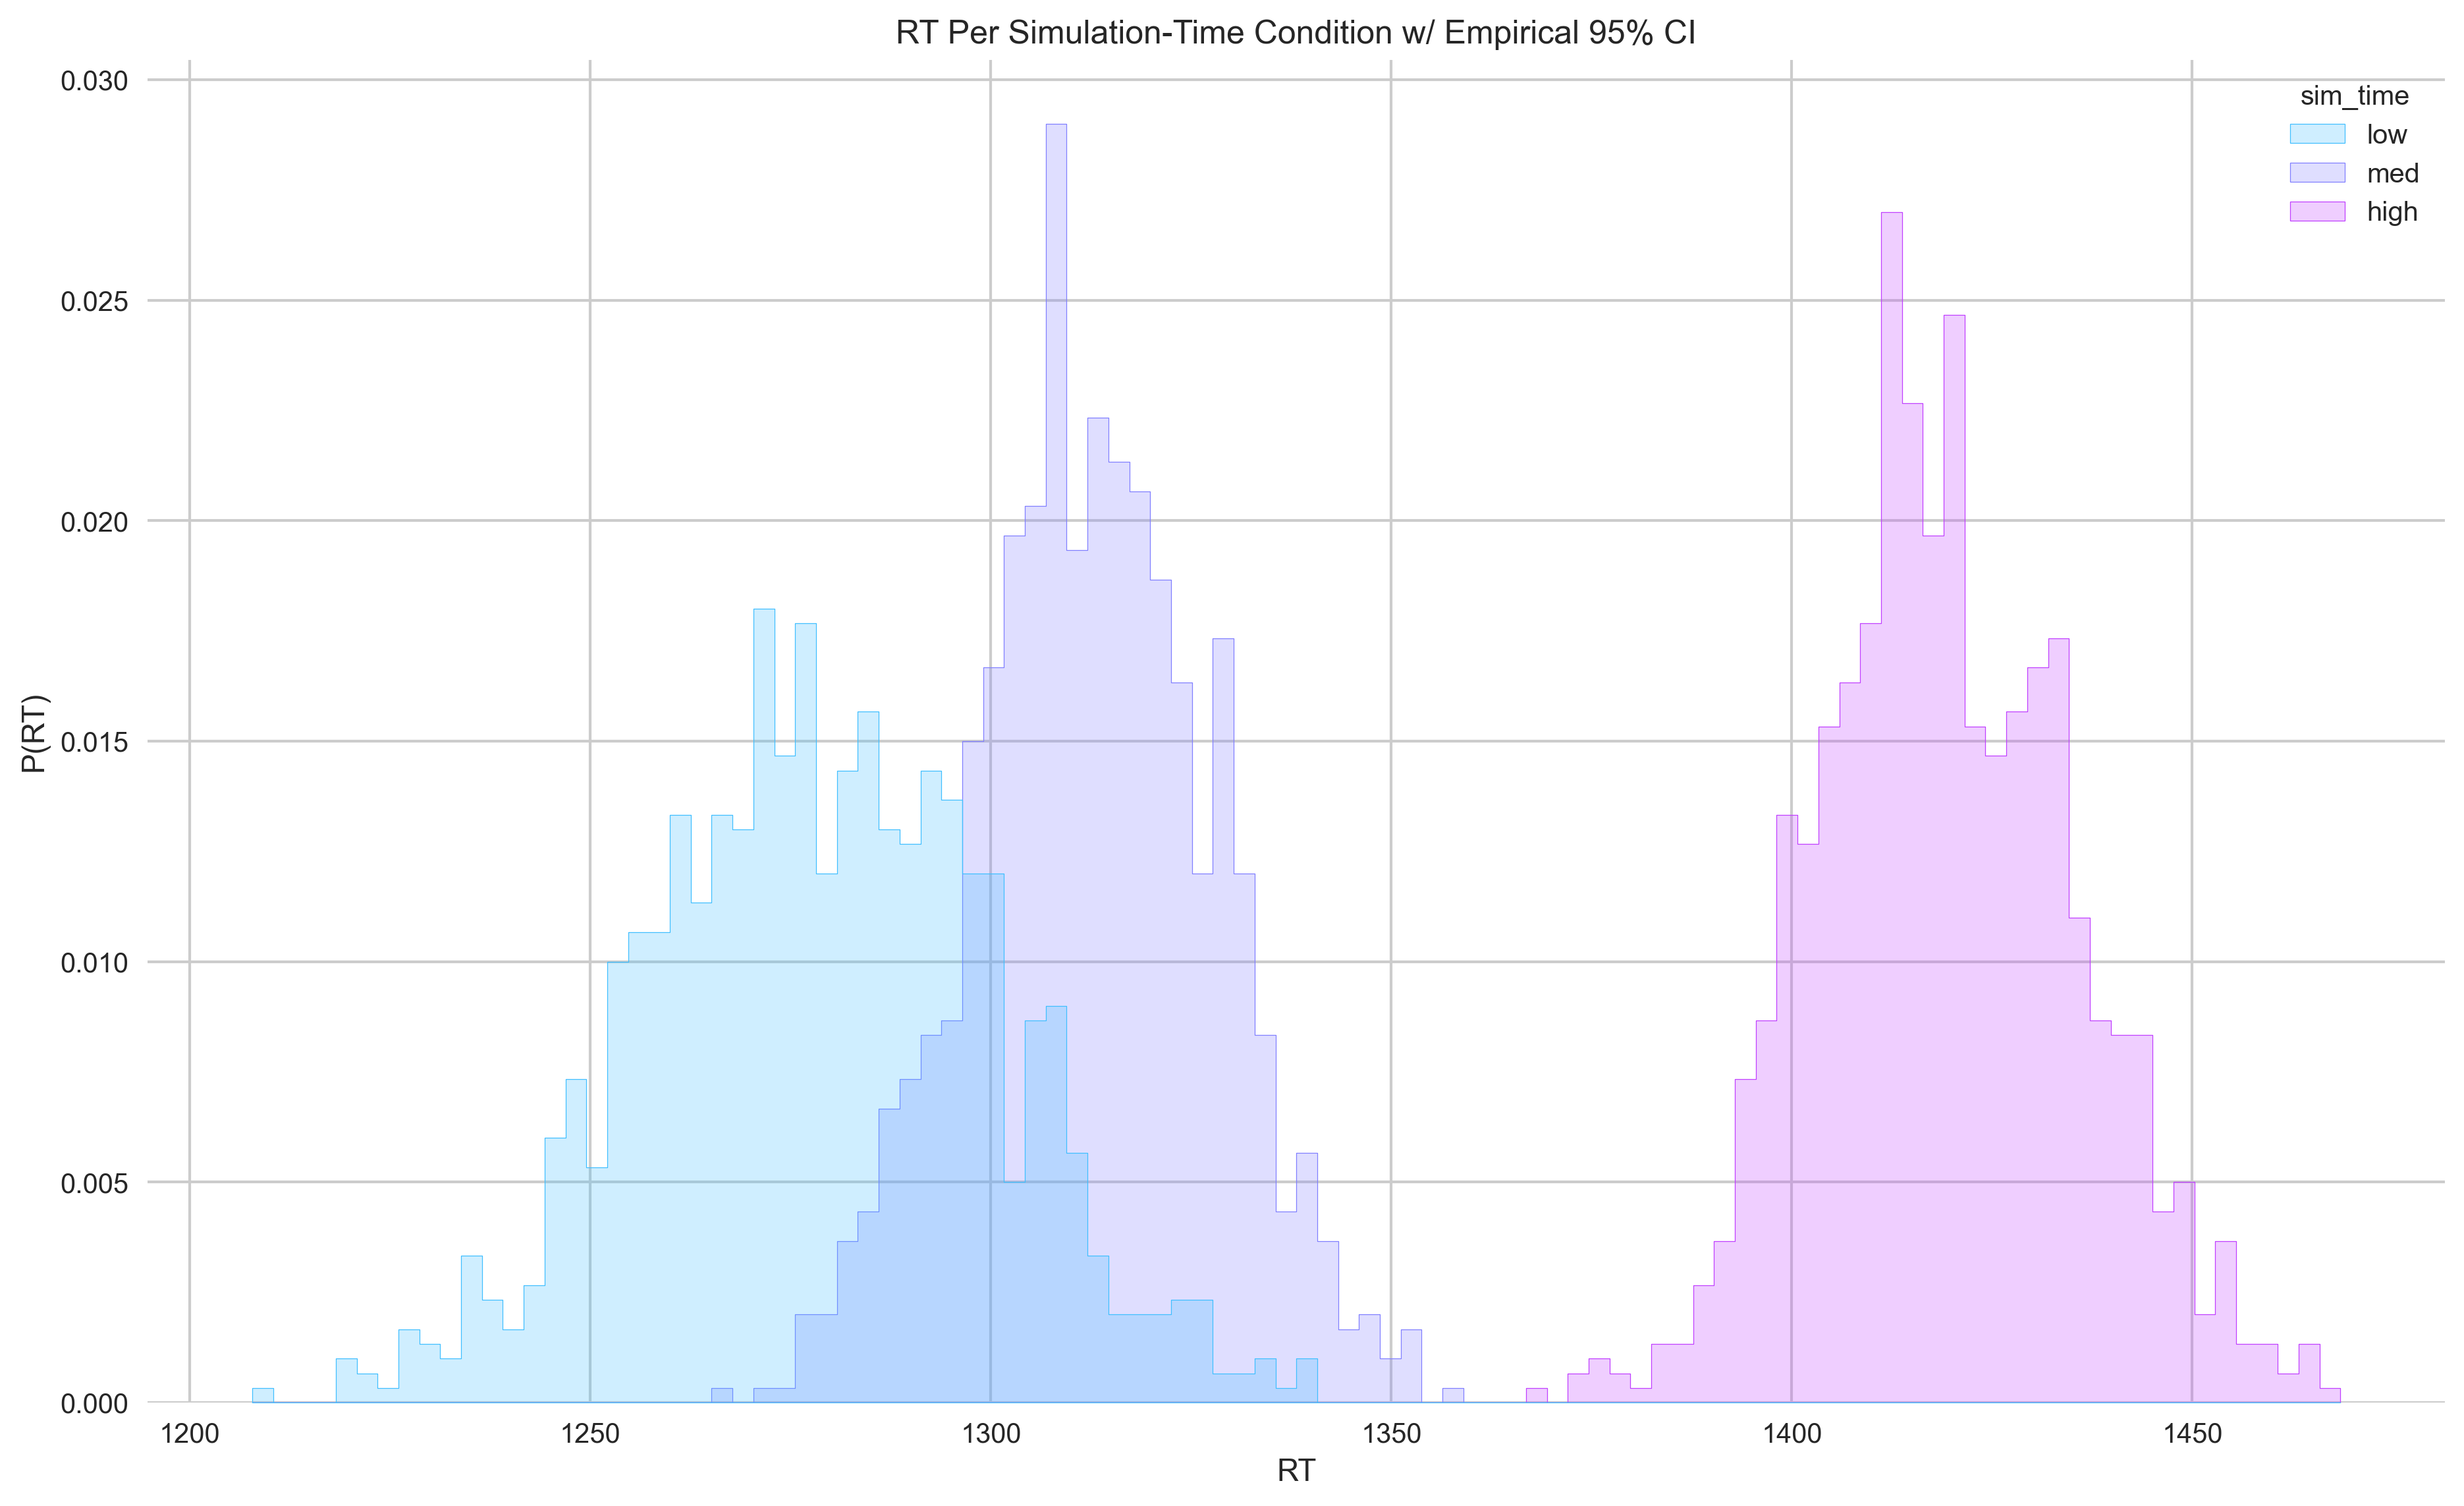

In [719]:
low_d = {'rt': low_bs_samples,'sim_time':["low"]*len(low_bs_samples)}
med_d = {'rt': med_bs_samples,'sim_time':["med"]*len(med_bs_samples)}
high_d = {'rt': high_bs_samples,'sim_time':["high"]*len(high_bs_samples)}

df = pd.DataFrame([low_d,med_d,high_d])
df = df.explode("rt")
df['sim_time'] = df.sim_time.apply(lambda x: x[0])

sns.histplot(x="rt",data=df,hue="sim_time",bins=100,element="step",palette="cool",stat="probability")

plt.title("RT Per Simulation-Time Condition w/ Empirical 95% CI")
plt.xlabel("RT")
plt.ylabel("P(RT)")

# RT for scenes that are "obvious"

#### Conclusions
1. Obvious scenes have significantly lower RT, RT(Obv) < RT(NotObv) (MWU, p = 3e-32)
2. The relation is preserved within simulation time conditions RT(ObvMed) < RT(ObvHigh) (MWU, p = 4.4e-7) 

Text(0, 0.5, 'P(RT)')

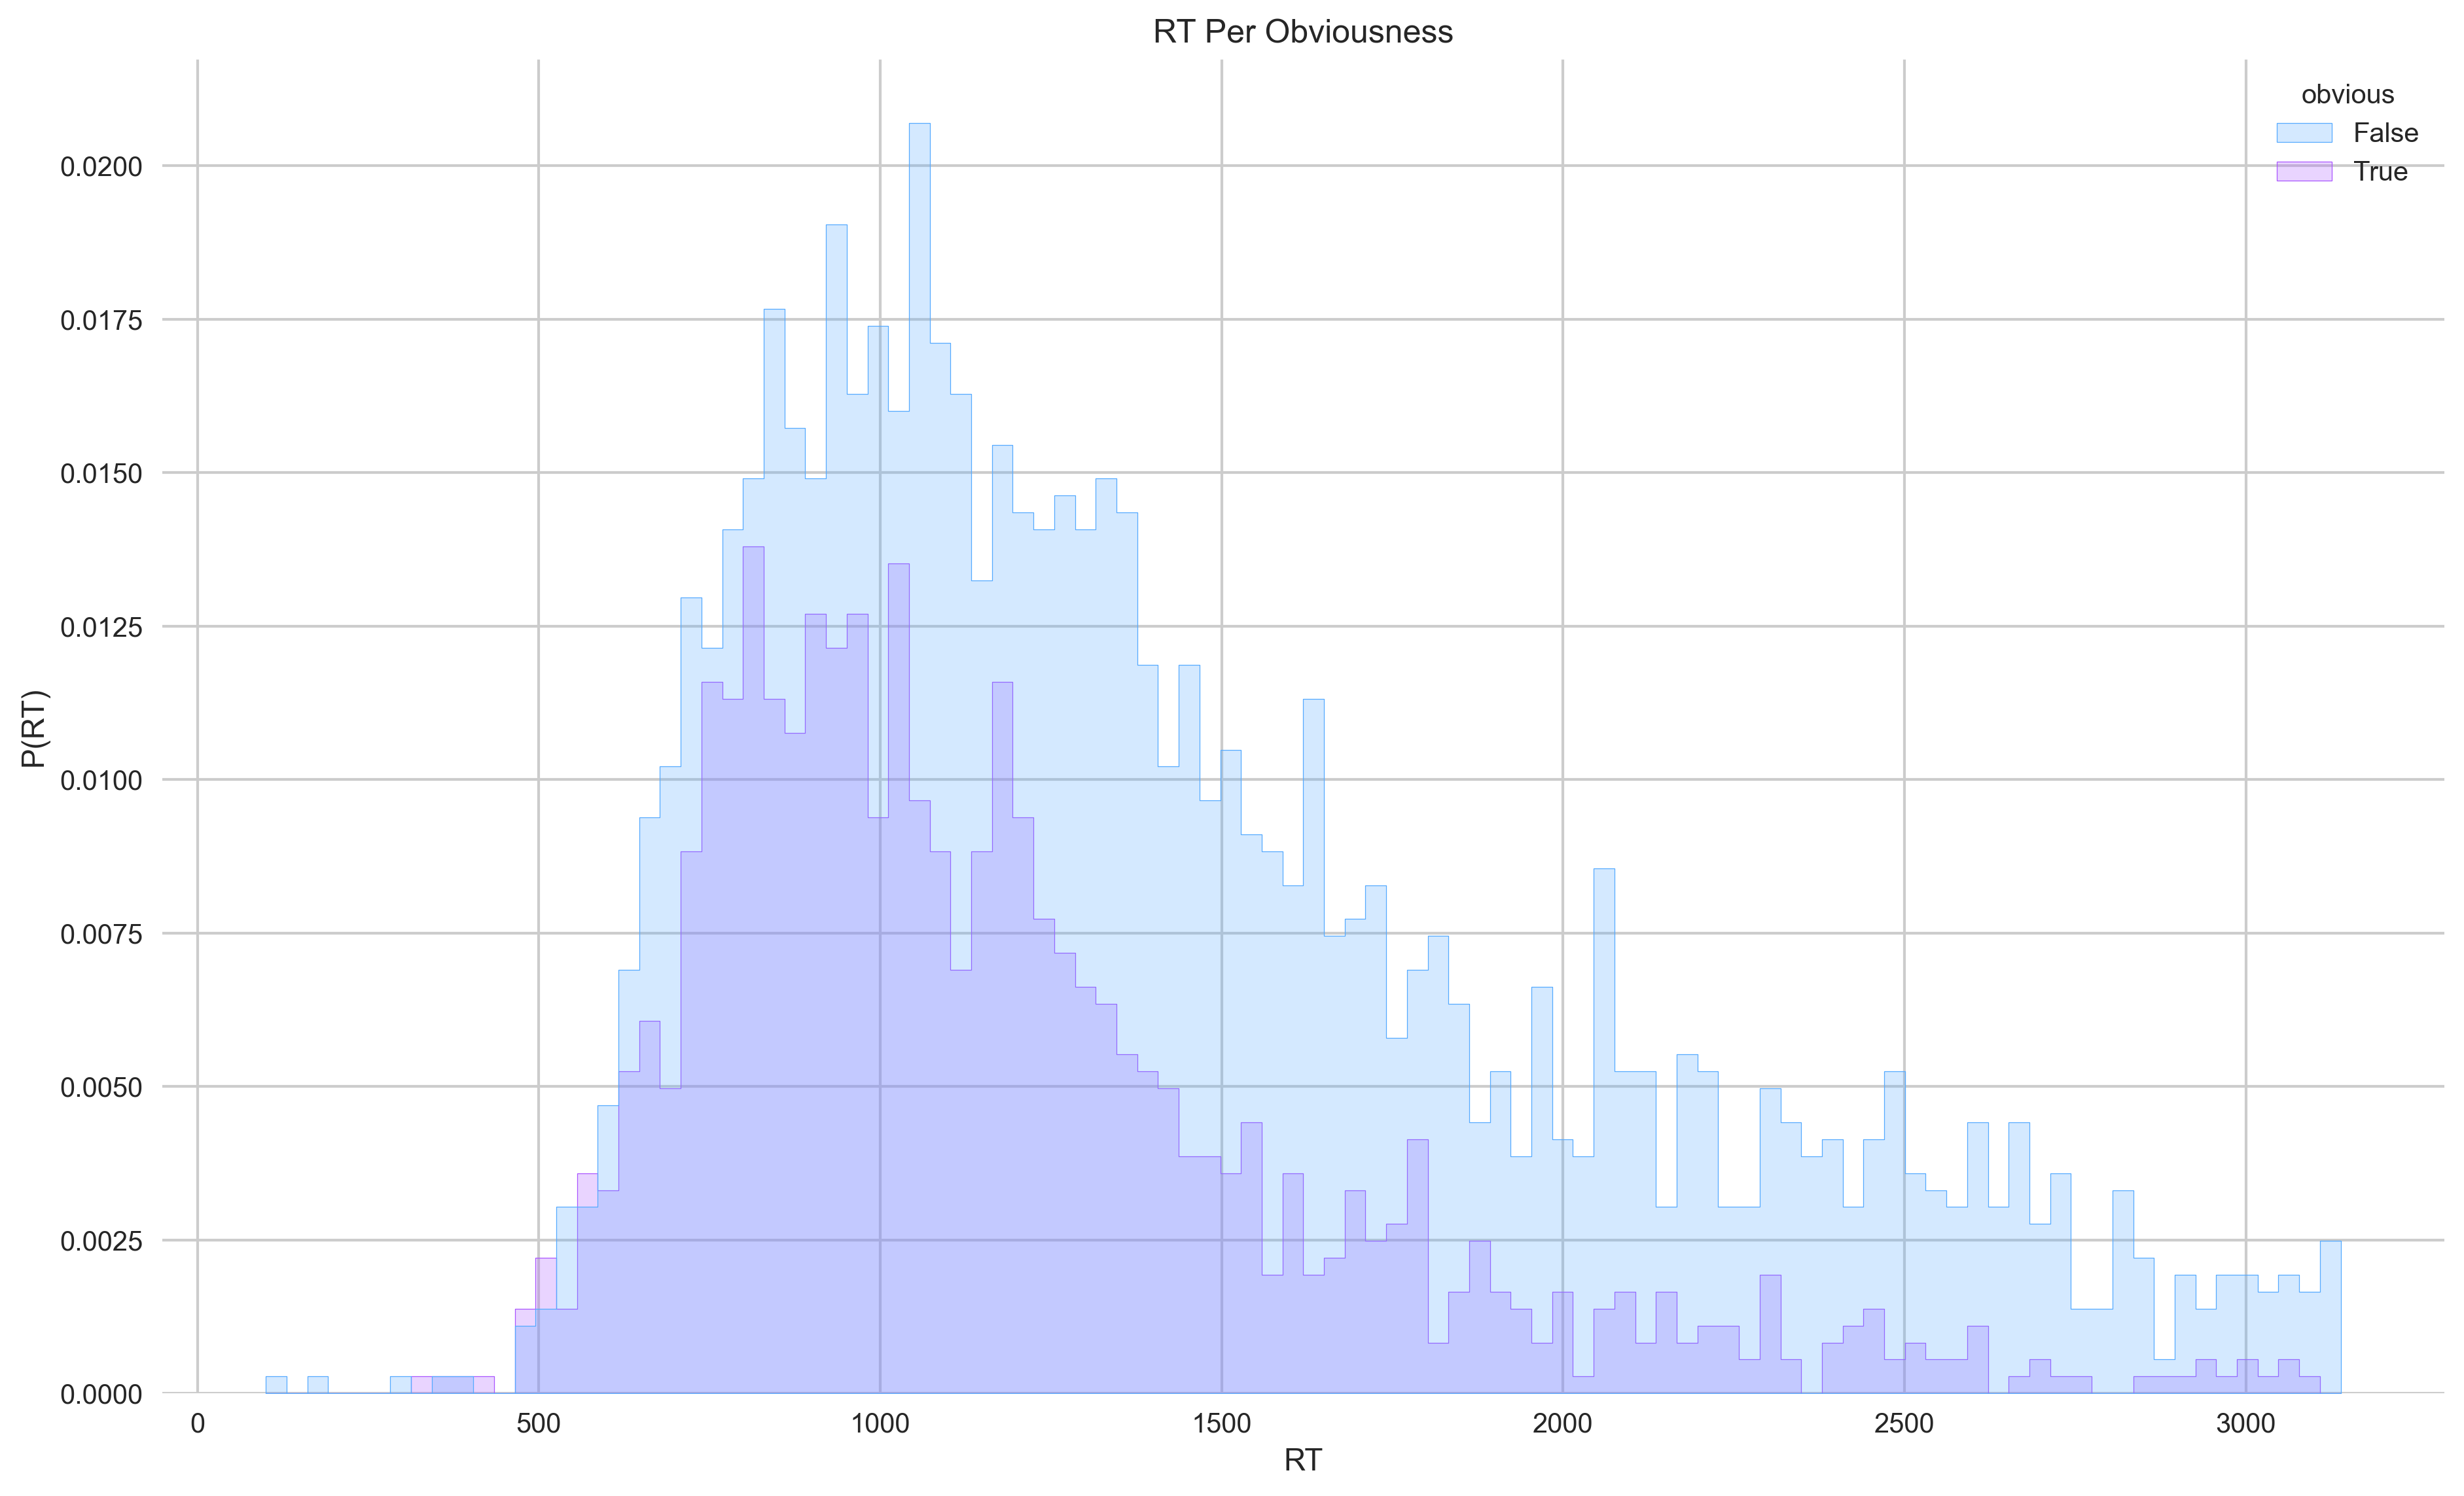

In [777]:
sns.histplot(x="rt",data=clean_responses,hue="obvious",bins=100,element="step",palette="cool",stat="probability")

plt.title("RT Per Obviousness")
plt.xlabel("RT")
plt.ylabel("P(RT)")

In [779]:
# RT for medium-no condition
obvious = list(clean_responses[(clean_responses["obvious"]==True)].rt)
not_obvious = list(clean_responses[(clean_responses["obvious"]==False)].rt)
u_res = mannwhitneyu(obvious, not_obvious, alternative="less")
print(f"U test statistic: {u_res}")

U test statistic: MannwhitneyuResult(statistic=1099575.0, pvalue=3.436837783705006e-32)


## RT per obviousness and simulation time condition

Text(0, 0.5, 'P(RT)')

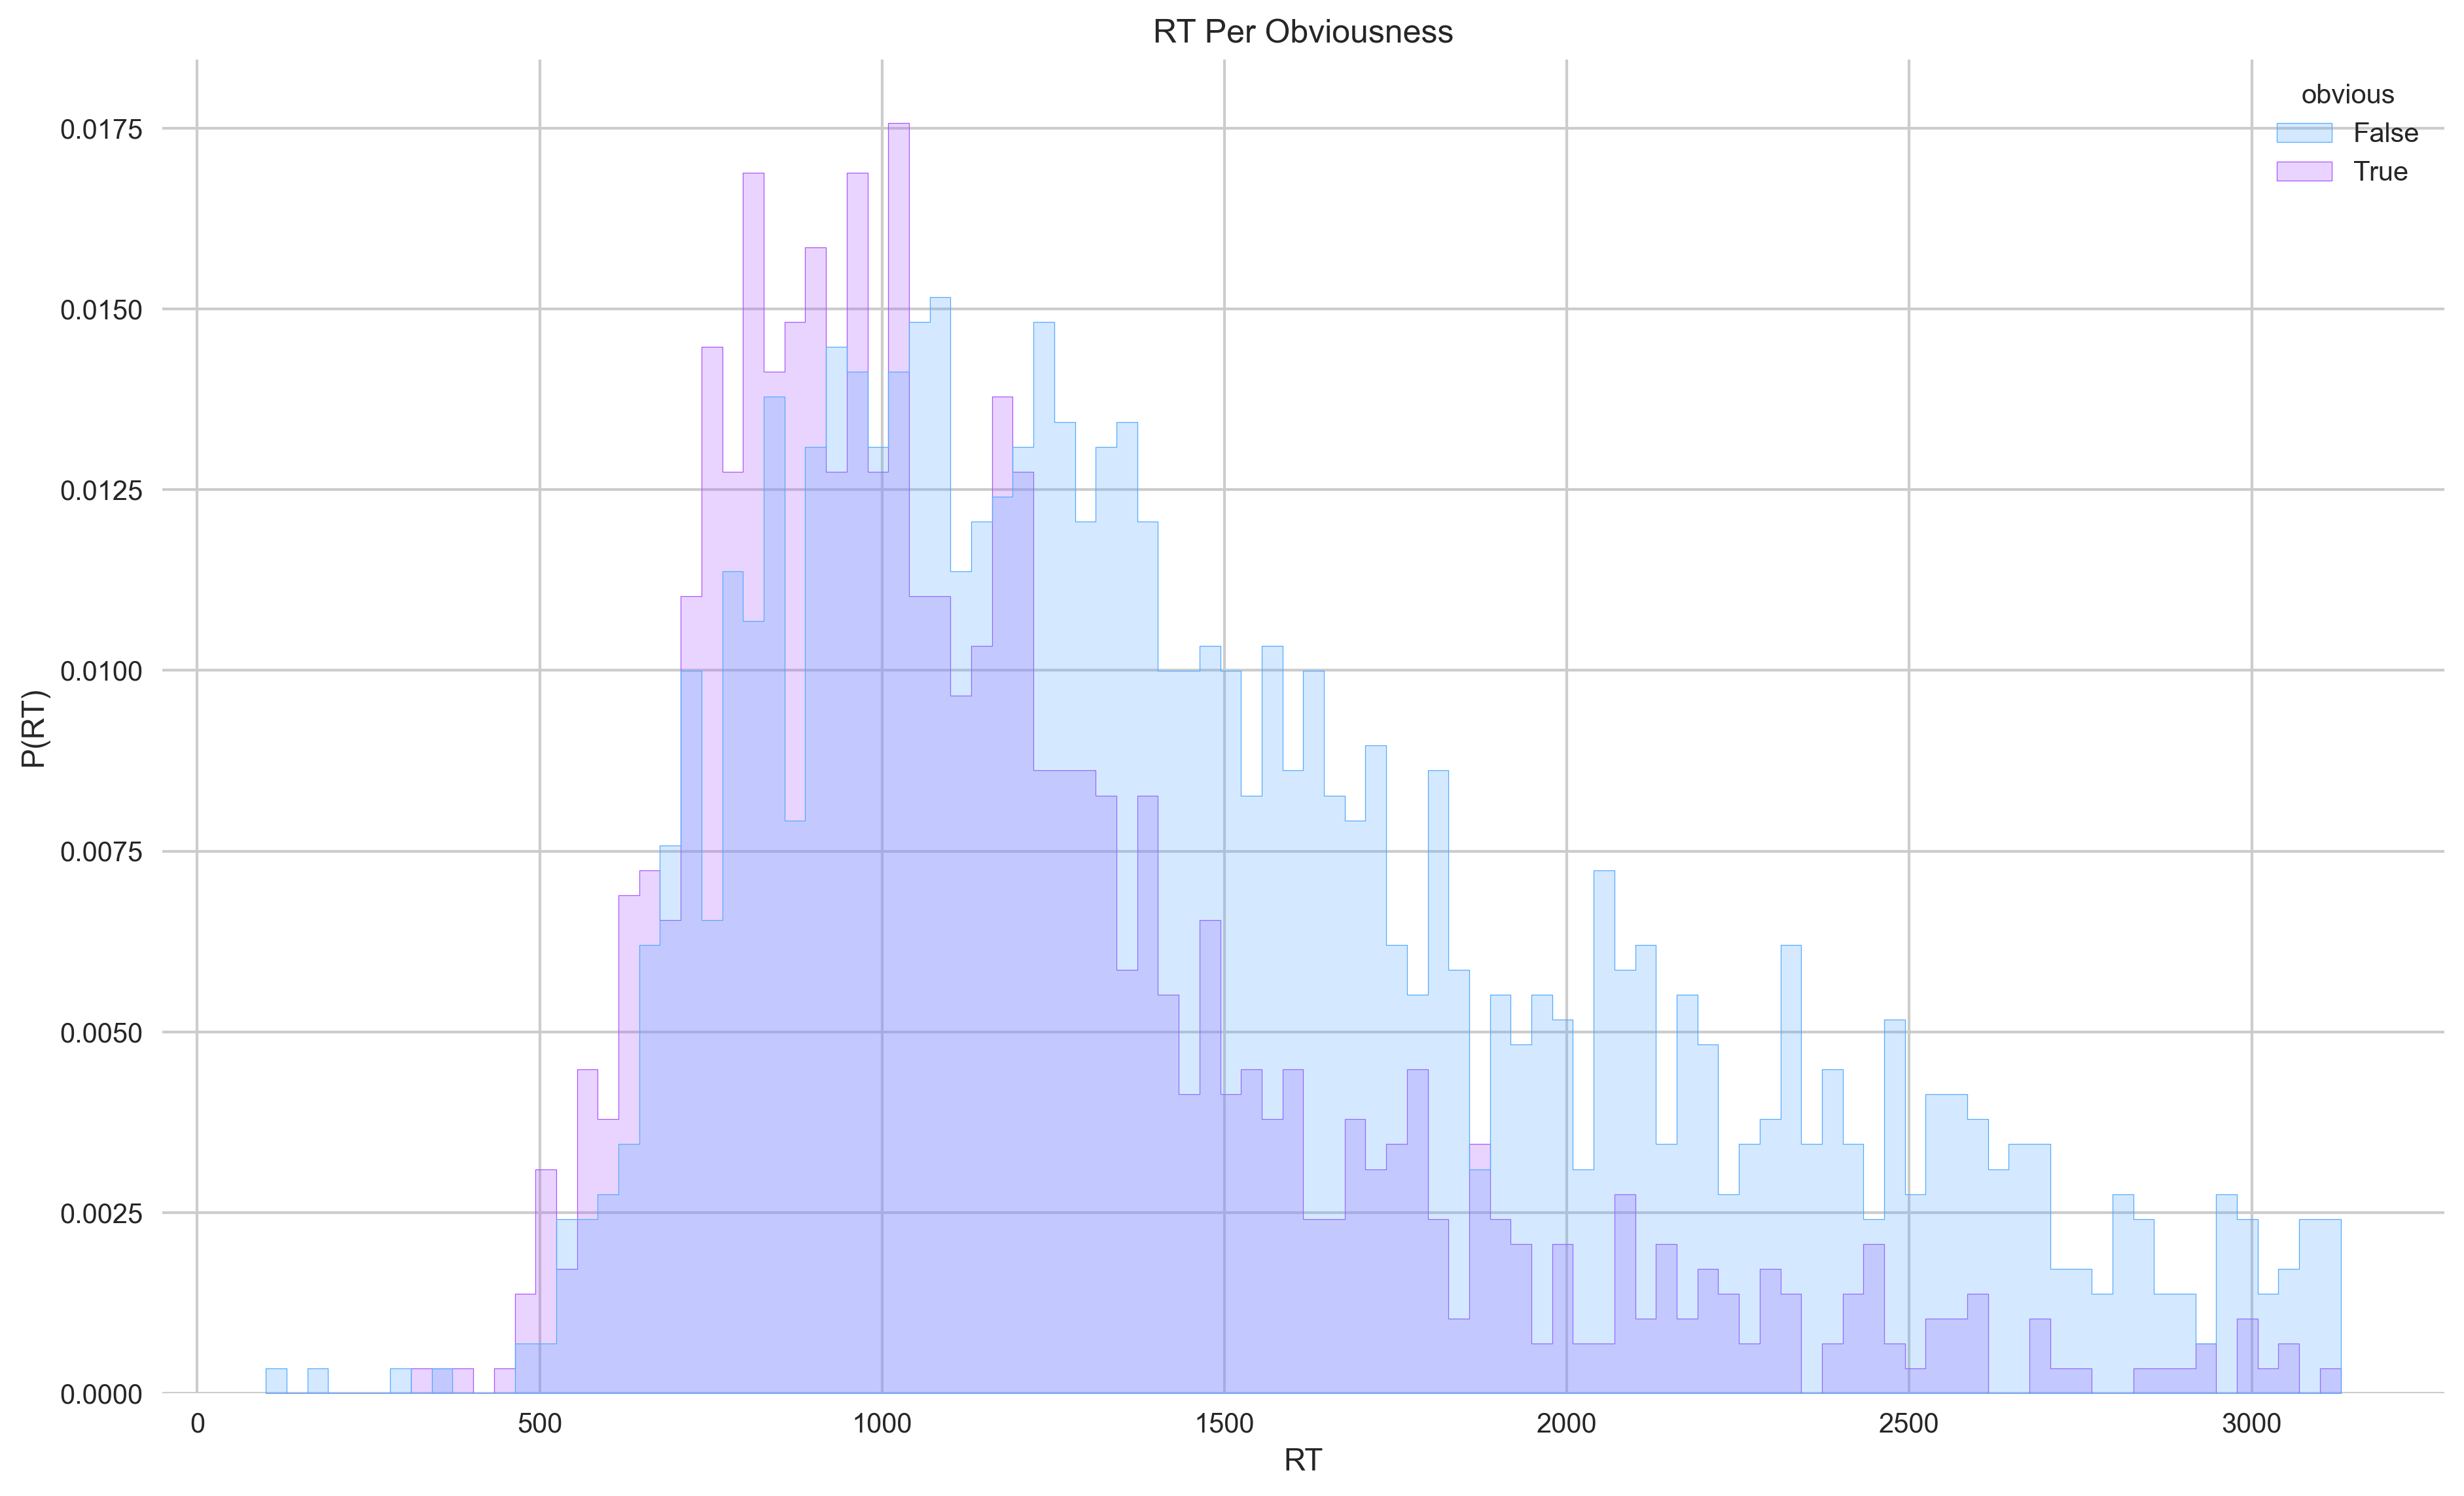

In [782]:
df = clean_responses[(clean_responses.sim_time == "med") | (clean_responses.sim_time == "high")]
sns.histplot(x="rt",data=df,hue="obvious",bins=100,element="step",palette="cool",stat="probability")

plt.title("RT Per Obviousness")
plt.xlabel("RT")
plt.ylabel("P(RT)")

In [785]:
# RT for medium-no condition
med_obvious = list(clean_responses[(clean_responses["obvious"]==True) & (clean_responses["sim_time"]=="med")].rt)
high_obvious = list(clean_responses[(clean_responses["obvious"]==True) & (clean_responses["sim_time"]=="high")].rt)
u_res = mannwhitneyu(med_obvious, high_obvious, alternative="less")
print(f"U test statistic: {u_res}")

U test statistic: MannwhitneyuResult(statistic=135819.5, pvalue=4.447719945054231e-07)


In [ ]:
med_obvious = list(clean_responses[(clean_responses["obvious"]==True) & (clean_responses["sim_time"]=="med")].rt)
low_obvious = list(clean_responses[(clean_responses["obvious"]==True) & (clean_responses["sim_time"]=="low")].rt)
u_res = mannwhitneyu(med_obvious, high_obvious, alternative="less")
print(f"U test statistic: {u_res}")

# Model

In [849]:
model = pd.read_json("model_outputs.json")

In [850]:
sprt = model['sprt'].apply(pd.Series)
sprt["model"] = 'sprt'
sprt = sprt.rename(columns={'probchoice':'p_sprt','samples': 'rt_sprt'})

det = model['deterministic'].apply(pd.Series)
det["model"] = 'deterministic'
det = det.rename(columns={'probchoice':'p_det','samples': 'rt_det'})

stoch = model['stochastic'].apply(pd.Series)
stoch["model"] = 'stochastic'
stoch = stoch.rename(columns={'probchoice':'p_stoch','samples': 'rt_stoch'})

abst = model['abstraction'].apply(pd.Series)
abst["model"] = 'abstraction'
abst = abst.rename(columns={'probchoice':'p_abs','samples': 'rt_abs'})

In [851]:
model = pd.concat([sprt,det,stoch,abst])
model

,scene,p_sprt,rt_sprt,model,p_det,rt_det,p_stoch,rt_stoch,p_abs,rt_abs
0,med_no14,0.0,1374.0,sprt,NaN,NaN,NaN,NaN,NaN,NaN
1,high_yes14,1.0,806.0,sprt,NaN,NaN,NaN,NaN,NaN,NaN
2,low_no6,0.0,672.0,sprt,NaN,NaN,NaN,NaN,NaN,NaN
3,med_yes10,1.0,806.0,sprt,NaN,NaN,NaN,NaN,NaN,NaN
4,high_yes6,1.0,808.0,sprt,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
70,low_no5,NaN,NaN,abstraction,NaN,NaN,NaN,NaN,0.0,209.0
71,med_yes13,NaN,NaN,abstraction,NaN,NaN,NaN,NaN,0.0,205.0
72,high_yes5,NaN,NaN,abstraction,NaN,NaN,NaN,NaN,0.0,365.0
73,med_no1,NaN,NaN,abstraction,NaN,NaN,NaN,NaN,0.0,323.0


In [852]:
model = model.apply(lambda x: pd.Series(x.dropna().values))

In [853]:
model = model.iloc[0:75]
model.drop(['model'], axis=1)

,scene,p_sprt,rt_sprt,p_det,rt_det,p_stoch,rt_stoch,p_abs,rt_abs
0,med_no14,0.0,1374.0,0.0,337.0,0.00,345.28,0.0,346.0
1,high_yes14,1.0,806.0,1.0,201.0,0.90,260.08,0.0,345.0
2,low_no6,0.0,672.0,0.0,171.0,0.00,167.45,0.0,181.0
3,med_yes10,1.0,806.0,1.0,201.0,0.99,201.89,1.0,2.0
4,high_yes6,1.0,808.0,1.0,201.0,0.71,231.90,1.0,2.0
...,...,...,...,...,...,...,...,...,...
70,low_no5,0.0,734.0,0.0,184.0,0.00,176.64,0.0,209.0
71,med_yes13,1.0,956.0,1.0,275.0,0.97,244.77,0.0,205.0
72,high_yes5,1.0,6924.0,1.0,409.0,0.77,414.04,0.0,365.0
73,med_no1,0.0,1302.0,0.0,303.0,0.01,321.06,0.0,323.0


In [861]:
clean_responses = clean_responses.merge(model, on="scene")

In [884]:
clean_responses.corr()

,trial_index,rt,scene_index,zrt,log_rt,zlogrt,participant_accuracy,trial_accuracy,scene_accuracy,obvious,p_sprt,rt_sprt,p_det,rt_det,p_stoch,rt_stoch,p_abs,rt_abs
trial_index,1.000000,-0.113028,-0.005618,-0.113028,-0.106890,-0.106890,-0.001907,0.110222,0.001598,-0.001382,-0.006407,0.004729,-0.002465,-0.010462,-0.004062,-0.005245,0.001832,-0.014808
rt,-0.113028,1.000000,0.081537,1.000000,0.970077,0.970077,-0.098264,-0.040360,-0.151759,-0.197063,-0.155311,0.153265,-0.134986,0.208694,-0.161696,0.225436,-0.220221,0.220682
scene_index,-0.005618,0.081537,1.000000,0.081537,0.092338,0.092338,-0.002920,-0.032856,-0.380389,0.105101,0.274009,0.352221,0.338498,0.495940,0.263625,0.643568,0.059916,0.398819
zrt,-0.113028,1.000000,0.081537,1.000000,0.970077,0.970077,-0.098264,-0.040360,-0.151759,-0.197063,-0.155311,0.153265,-0.134986,0.208694,-0.161696,0.225436,-0.220221,0.220682
log_rt,-0.106890,0.970077,0.092338,0.970077,1.000000,1.000000,-0.099067,-0.043258,-0.159459,-0.194096,-0.147927,0.159085,-0.129031,0.204736,-0.154256,0.227668,-0.220610,0.225530
zlogrt,-0.106890,0.970077,0.092338,0.970077,1.000000,1.000000,-0.099067,-0.043258,-0.159459,-0.194096,-0.147927,0.159085,-0.129031,0.204736,-0.154256,0.227668,-0.220610,0.225530
participant_accuracy,-0.001907,-0.098264,-0.002920,-0.098264,-0.099067,-0.099067,1.000000,-0.004682,0.006778,-0.006311,-0.008552,0.002386,-0.007306,-0.001213,-0.008827,0.000906,-0.006804,0.003729
trial_accuracy,0.110222,-0.040360,-0.032856,-0.040360,-0.043258,-0.043258,-0.004682,1.000000,0.094912,0.015037,-0.019815,-0.038966,-0.024419,-0.029363,-0.019940,-0.041883,0.027221,-0.034742
scene_accuracy,0.001598,-0.151759,-0.380389,-0.151759,-0.159459,-0.159459,0.006778,0.094912,1.000000,0.184414,-0.224220,-0.270195,-0.297907,-0.356594,-0.231844,-0.429472,0.215717,-0.315937
obvious,-0.001382,-0.197063,0.105101,-0.197063,-0.194096,-0.194096,-0.006311,0.015037,0.184414,1.000000,0.843435,-0.153986,0.760709,-0.383096,0.832665,-0.436783,0.848547,-0.612978


In [881]:
import statsmodels.formula.api as sm
df = clean_responses[clean_responses.collision == "yes"]
result = sm.ols(formula="rt ~ rt_sprt + p_sprt", data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     38.84
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           6.01e-10
Time:                        14:23:29   Log-Likelihood:                -11271.
No. Observations:                1475   AIC:                         2.255e+04
Df Residuals:                    1473   BIC:                         2.256e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    575.7026      9.631     59.773      0.0

In [882]:
df = clean_responses[clean_responses.collision == "yes"]
result = sm.ols(formula="rt ~ rt_abs + p_abs", data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     69.66
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.24e-29
Time:                        14:23:34   Log-Likelihood:                -11224.
No. Observations:                1475   AIC:                         2.245e+04
Df Residuals:                    1472   BIC:                         2.247e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1427.0620    110.692     12.892      0.0

In [883]:
df = clean_responses[clean_responses.collision == "yes"]
result = sm.ols(formula="rt ~ rt_stoch + p_stoch", data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     56.89
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.59e-24
Time:                        14:23:37   Log-Likelihood:                -11236.
No. Observations:                1475   AIC:                         2.248e+04
Df Residuals:                    1472   BIC:                         2.249e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1640.3774    201.077      8.158      0.0